In [3]:
# przetwarzanie danych
import numpy as np
import pandas as pd

# przekształcanie – normalizacja danych
from sklearn.preprocessing import MinMaxScaler

# wizualizacja
import matplotlib.pyplot as plt
!pip install tensorflow
# sieci neuronowe
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import GRU

# ewaluacja modelu
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping

In [4]:
dataset = pd.read_csv('airline-passengers.csv')
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.set_index(['Month'], inplace=True)
dataset

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


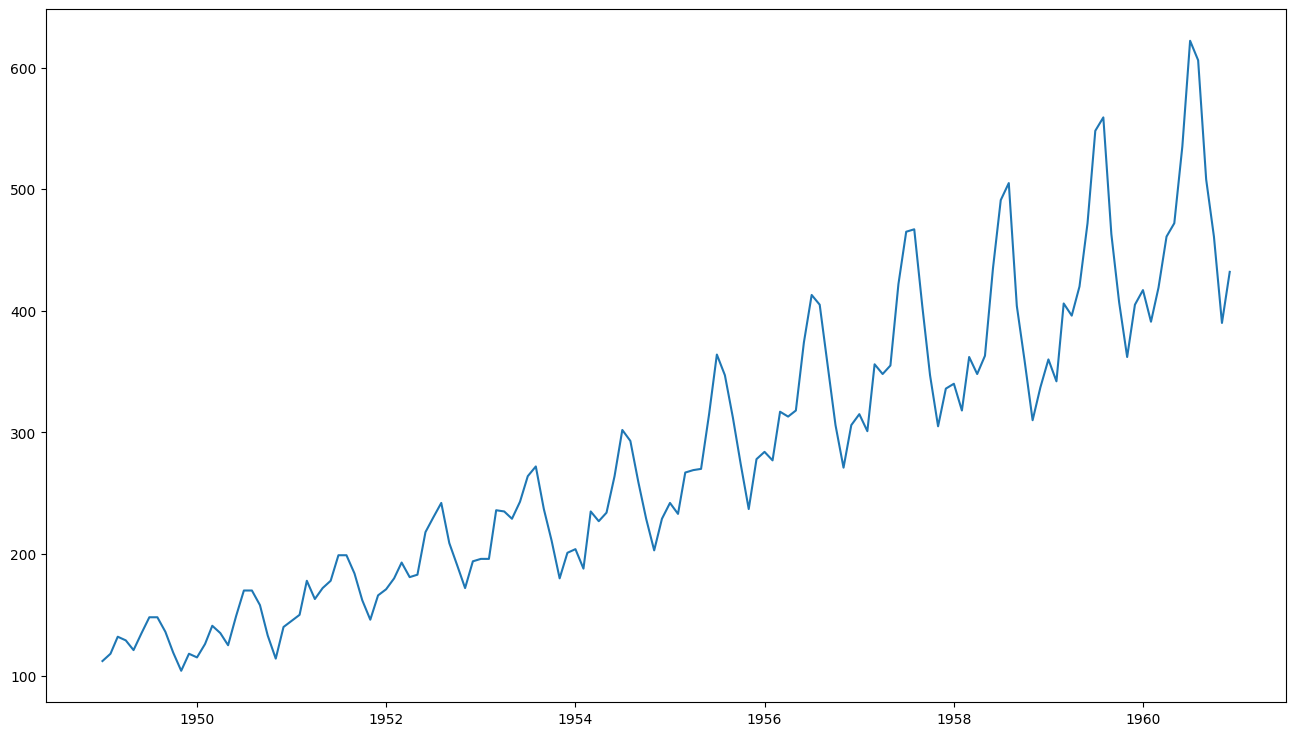

In [5]:
plt.figure(figsize=(16,9))
plt.plot(dataset['Passengers'])
plt.show()

#Przygotowanie i podział danych#


In [6]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Tworzenie skalera
scaler = MinMaxScaler(feature_range=(0, 1))

def create_dataset(df, train_size, val_size, look_back, scaler_function=scaler):
    # Podział zbioru na train, val, test
    train = df[:train_size, :].copy()
    val = df[train_size:train_size + val_size, :].copy() if train_size + val_size < len(df) else np.empty((0, df.shape[1]))
    test = df[train_size + val_size:, :].copy() if train_size + val_size < len(df) else np.empty((0, df.shape[1]))

    # Skalowanie danych
    train = scaler_function.fit_transform(train)
    val = scaler_function.transform(val) if len(val) > 0 else val
    test = scaler_function.transform(test) if len(test) > 0 else test

    # Inicjalizacja pustych list
    X_train, y_train, X_test, y_test, X_val, y_val = [], [], [], [], [], []

    # Tworzenie zbioru treningowego
    if len(train) > look_back:
        for i in range(len(train) - look_back):
            X_train.append(train[i:(i + look_back), 0])
            y_train.append(train[i + look_back, 0])

    # Tworzenie zbioru walidacyjnego (jeśli istnieje)
    if len(val) > look_back:
        for i in range(len(val) - look_back):
            X_val.append(val[i:(i + look_back), 0])
            y_val.append(val[i + look_back, 0])

    # Tworzenie zbioru testowego (jeśli istnieje)
    if len(test) > look_back:
        for i in range(len(test) - look_back):
            X_test.append(test[i:(i + look_back), 0])
            y_test.append(test[i + look_back, 0])

    # Konwersja list na tablice NumPy
    X_train, X_test, X_val = np.array(X_train), np.array(X_test), np.array(X_val)
    y_train, y_test, y_val = np.array(y_train), np.array(y_test), np.array(y_val)

    # Reshape dla RNN (batch_size, timesteps, input_dim)
    if len(X_train) > 0:
        X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    if len(X_test) > 0:
        X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    if len(X_val) > 0:
        X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

    return X_train, X_test, X_val, y_train, y_test, y_val

# Ustawienia podziału zbioru
train_size = int(len(dataset) * 0.7)
val_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - val_size  # Reszta jako test

#Declaration of models#

In [7]:
def model_rnn_func(units, look_back):
    model_rnn = Sequential()
    model_rnn.add(SimpleRNN(units, input_shape=(1, look_back)))
    model_rnn.add(Dense(1))
    model_rnn.compile(loss='mean_squared_error', optimizer='adam')
    return model_rnn

In [8]:
def model_lstm_func(units, look_back):
    model_lstm = Sequential()
    model_lstm.add(LSTM(units, input_shape=(1, look_back)))
    model_lstm.add(Dense(1))
    model_lstm.compile(loss='mean_squared_error', optimizer='adam')
    return model_lstm

In [9]:
def model_gru_func(units, look_back):
    model_gru = Sequential()
    model_gru.add(GRU(units, input_shape=(1, look_back)))
    model_gru.add(Dense(1))
    model_gru.compile(loss='mean_squared_error', optimizer='adam')
    return model_gru

In [10]:
models = [model_rnn_func, model_lstm_func, model_gru_func]

In [11]:
es = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True, mode = 'min')

#Liczenie wartosci do wizualizacji#

In [12]:
results_df = pd.DataFrame(columns=["Model_Name", "Look_Back", "Units", "RMSE val"])
def backtests(model, lback, model_num):
    global results_df

    if model_num == 0:
        model_name = f"RNN_LB{look_back}_U{units}"
    elif model_num == 1:
        model_name = f"LSTM_LB{look_back}_U{units}"
    else:
        model_name = f"GRU_LB{look_back}_U{units}"


    train_index = dataset.index[look_back:look_back + len(y_train)]  # Uwzględnienie przesunięcia o look_back
    test_index = dataset.index[len(y_train) + len(y_val): len(y_train) + len(y_val) + len(y_test)]  # Dla testowego

    prediction_train = model.predict(X_train)
    prediction_train = scaler.inverse_transform(prediction_train)

    # Poprawione indeksowanie
    prediction_train = pd.Series(prediction_train.flatten(),
                                 index=train_index)

    # Predykcja - test
    prediction_test = model.predict(X_test)
    prediction_test = scaler.inverse_transform(prediction_test)

    prediction_test = pd.Series(prediction_test.flatten(),
                                index=test_index)

    prediction_val = model.predict(X_val)
    prediction_val = scaler.inverse_transform(prediction_val)
    start_val_index = len(prediction_train) + len(prediction_test) + (3 * lback) + 1
    prediction_val = pd.Series(prediction_val.flatten()[:len(dataset.index[start_val_index:])],
                                  index=dataset.index[start_val_index:])

    true_val_values = dataset.loc[prediction_val.index, 'Passengers']
    rmse_val = np.sqrt(mean_squared_error(true_val_values, prediction_val))

    results_df = pd.concat([results_df, pd.DataFrame([{"Model_Name": model_name,
                                                        "Look_Back": lback,
                                                        "Units": units,
                                                        "RMSE val": rmse_val}])], ignore_index=True)

    return results_df

#Val_loss for validation datas#

In [13]:
epochs=200

In [14]:
for look_back in range(1, 13):
  X_train, X_test, X_val, y_train, y_test, y_val = create_dataset(np.array(dataset), train_size, val_size, look_back)
  for units in range(1, 13):
    model_num = 0
    for model in models:
      model = model(units, look_back)
      model.fit(X_train, y_train, epochs= epochs, batch_size=1, verbose=1, validation_data = (X_val, y_val), callbacks=[es])
      results_df = backtests(model, look_back, model_num)
      model_num += 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0343 - val_loss: 0.0788
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0127 - val_loss: 0.0582
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0152 - val_loss: 0.0511
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0114 - val_loss: 0.0458
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0079 - val_loss: 0.0427
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0087 - val_loss: 0.0377
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0067 - val_loss: 0.0316
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0061 - val_loss: 0.0303
Epoch 9/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0058 - val_loss: 0.0266
Epoch 10/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0061 - val_loss: 0.0258
Epoch 11/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0059 - val_loss: 0.0269
Epoch 12/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss:

<ipython-input-12-2d0c021c2b6b>:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([{"Model_Name": model_name,
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1934 - val_loss: 0.7056
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1181 - val_loss: 0.5922
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0784 - val_loss: 0.5089
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0834 - val_loss: 0.4439
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0824 - val_loss: 0.3998
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0721 - val_loss: 0.3698
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0637 - val_loss: 0.3470
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0729 - val_loss: 0.3270
Epoch 9/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0533 - val_loss: 0.3165
Epoch 10/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0676 - val_loss: 0.3048
Epoch 11/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0611 - val_loss: 0.2987
Epoch 12/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0520 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0411 - val_loss: 0.1219
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0161 - val_loss: 0.0854
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0126 - val_loss: 0.0740
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0166 - val_loss: 0.0675
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0134 - val_loss: 0.0617
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0106 - val_loss: 0.0523
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084 - val_loss: 0.0470
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061 - val_loss: 0.0380
Epoch 9/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 - val_loss: 0.0378
Epoch 10/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054 - val_loss: 0.0305
Epoch 11/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0062 - val_loss: 0.0343
Epoch 12/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0062 - val_lo

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0462 - val_loss: 0.0998
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0133 - val_loss: 0.0725
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0155 - val_loss: 0.0635
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0092 - val_loss: 0.0473
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0078 - val_loss: 0.0425
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0094 - val_loss: 0.0387
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - val_loss: 0.0317
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064 - val_loss: 0.0246
Epoch 9/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064 - val_loss: 0.0242
Epoch 10/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0080 - val_loss: 0.0260
Epoch 11/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - val_loss: 0.0211
Epoch 12/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2289 - val_loss: 0.8229
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1313 - val_loss: 0.6305
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0855 - val_loss: 0.5064
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0733 - val_loss: 0.4170
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0691 - val_loss: 0.3532
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0562 - val_loss: 0.3186
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0510 - val_loss: 0.2861
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0520 - val_loss: 0.2665
Epoch 9/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0640 - val_loss: 0.2524
Epoch 10/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0500 - val_loss: 0.2407
Epoch 11/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0597 - val_loss: 0.2244
Epoch 12/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0451 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1332 - val_loss: 0.4270
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0797 - val_loss: 0.2690
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0390 - val_loss: 0.1971
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0340 - val_loss: 0.1663
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0293 - val_loss: 0.1509
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0268 - val_loss: 0.1401
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0279 - val_loss: 0.1296
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0150 - val_loss: 0.1062
Epoch 9/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0188 - val_loss: 0.0908
Epoch 10/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0170 - val_loss: 0.0844
Epoch 11/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0142 - val_loss: 0.0721
Epoch 12/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0150 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5259 - val_loss: 1.2072
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2625 - val_loss: 0.7053
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1172 - val_loss: 0.4684
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1017 - val_loss: 0.3871
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0675 - val_loss: 0.3275
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0567 - val_loss: 0.2734
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0543 - val_loss: 0.2394
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0655 - val_loss: 0.2086
Epoch 9/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0418 - val_loss: 0.1723
Epoch 10/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0407 - val_loss: 0.1424
Epoch 11/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0302 - val_loss: 0.1213
Epoch 12/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0215 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1579 - val_loss: 0.6463
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1068 - val_loss: 0.4551
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0787 - val_loss: 0.3319
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0438 - val_loss: 0.2555
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0469 - val_loss: 0.2087
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0450 - val_loss: 0.1855
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0424 - val_loss: 0.1735
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0349 - val_loss: 0.1559
Epoch 9/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0337 - val_loss: 0.1465
Epoch 10/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0256 - val_loss: 0.1316
Epoch 11/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0343 - val_loss: 0.1223
Epoch 12/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0250 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1477 - val_loss: 0.3484
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0642 - val_loss: 0.1999
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0344 - val_loss: 0.1559
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0302 - val_loss: 0.1358
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0237 - val_loss: 0.1082
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0222 - val_loss: 0.1030
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0207 - val_loss: 0.0820
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0150 - val_loss: 0.0642
Epoch 9/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0122 - val_loss: 0.0618
Epoch 10/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0148 - val_loss: 0.0476
Epoch 11/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0129 - val_loss: 0.0459
Epoch 12/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3726 - val_loss: 0.9289
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1225 - val_loss: 0.4839
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0883 - val_loss: 0.3533
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0620 - val_loss: 0.2735
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0548 - val_loss: 0.2407
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0380 - val_loss: 0.1988
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0357 - val_loss: 0.1877
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0346 - val_loss: 0.1523
Epoch 9/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0291 - val_loss: 0.1343
Epoch 10/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0277 - val_loss: 0.1098
Epoch 11/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0212 - val_loss: 0.0951
Epoch 12/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0173 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1197 - val_loss: 0.3483
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0585 - val_loss: 0.1992
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0341 - val_loss: 0.1303
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0205 - val_loss: 0.1066
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0230 - val_loss: 0.0860
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0164 - val_loss: 0.0722
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0221 - val_loss: 0.0645
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0149 - val_loss: 0.0540
Epoch 9/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0101 - val_loss: 0.0478
Epoch 10/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0121 - val_loss: 0.0398
Epoch 11/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0104 - val_loss: 0.0362
Epoch 12/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0878 - val_loss: 0.1724
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0317 - val_loss: 0.1030
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0249 - val_loss: 0.0913
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0218 - val_loss: 0.0927
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0157 - val_loss: 0.0555
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0125 - val_loss: 0.0612
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0115 - val_loss: 0.0413
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0097 - val_loss: 0.0387
Epoch 9/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074 - val_loss: 0.0301
Epoch 10/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 - val_loss: 0.0242
Epoch 11/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066 - val_loss: 0.0241
Epoch 12/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9849 - val_loss: 2.3766
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4335 - val_loss: 1.5545
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2540 - val_loss: 1.0488
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1421 - val_loss: 0.7707
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1284 - val_loss: 0.6109
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1186 - val_loss: 0.5258
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0691 - val_loss: 0.4645
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0831 - val_loss: 0.3943
Epoch 9/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0633 - val_loss: 0.3514
Epoch 10/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0486 - val_loss: 0.2890
Epoch 11/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0542 - val_loss: 0.2517
Epoch 12/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0460 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1926 - val_loss: 0.6061
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0976 - val_loss: 0.3978
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0558 - val_loss: 0.2724
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0564 - val_loss: 0.2181
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0514 - val_loss: 0.1883
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0355 - val_loss: 0.1634
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0280 - val_loss: 0.1389
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0304 - val_loss: 0.1290
Epoch 9/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0306 - val_loss: 0.1047
Epoch 10/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0255 - val_loss: 0.1025
Epoch 11/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0204 - val_loss: 0.0809
Epoch 12/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0230 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1932 - val_loss: 0.4650
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0975 - val_loss: 0.2793
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0347 - val_loss: 0.1821
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0365 - val_loss: 0.1484
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0283 - val_loss: 0.1293
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0240 - val_loss: 0.0992
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0168 - val_loss: 0.0803
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0140 - val_loss: 0.0626
Epoch 9/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 - val_loss: 0.0549
Epoch 10/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071 - val_loss: 0.0368
Epoch 11/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093 - val_loss: 0.0360
Epoch 12/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3869 - val_loss: 0.8827
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1189 - val_loss: 0.4688
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0562 - val_loss: 0.2918
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0618 - val_loss: 0.2406
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0596 - val_loss: 0.2077
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0376 - val_loss: 0.1686
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0278 - val_loss: 0.1301
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0259 - val_loss: 0.1082
Epoch 9/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0196 - val_loss: 0.0861
Epoch 10/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0217 - val_loss: 0.0740
Epoch 11/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0125 - val_loss: 0.0582
Epoch 12/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1790 - val_loss: 0.5074
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0831 - val_loss: 0.3026
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0533 - val_loss: 0.2105
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0402 - val_loss: 0.1636
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0287 - val_loss: 0.1422
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0342 - val_loss: 0.1252
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0278 - val_loss: 0.1091
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0199 - val_loss: 0.0863
Epoch 9/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0188 - val_loss: 0.0732
Epoch 10/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0187 - val_loss: 0.0653
Epoch 11/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111 - val_loss: 0.0517
Epoch 12/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1370 - val_loss: 0.2348
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0395 - val_loss: 0.1523
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0277 - val_loss: 0.1116
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0256 - val_loss: 0.0799
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0227 - val_loss: 0.0760
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0146 - val_loss: 0.0548
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091 - val_loss: 0.0437
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0078 - val_loss: 0.0287
Epoch 9/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080 - val_loss: 0.0302
Epoch 10/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058 - val_loss: 0.0225
Epoch 11/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071 - val_loss: 0.0256
Epoch 12/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0059 - val_loss: 0.0224
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055 - val_loss: 0.0180
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056 - val_loss: 0.0187
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0052 - val_loss: 0.0195
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047 - val_loss: 0.0200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2102 - val_loss: 0.7365
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1363 - val_loss: 0.5254
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0941 - val_loss: 0.3815
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0511 - val_loss: 0.2925
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0487 - val_loss: 0.2448
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0470 - val_loss: 0.2239
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0505 - val_loss: 0.1926
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0343 - val_loss: 0.1800
Epoch 9/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0313 - val_loss: 0.1668
Epoch 10/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0410 - val_loss: 0.1542
Epoch 11/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0283 - val_loss: 0.1383
Epoch 12/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0267 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1672 - val_loss: 0.4551
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0830 - val_loss: 0.2673
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0384 - val_loss: 0.1952
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0391 - val_loss: 0.1800
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0343 - val_loss: 0.1386
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0266 - val_loss: 0.1244
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0235 - val_loss: 0.0916
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0157 - val_loss: 0.0702
Epoch 9/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118 - val_loss: 0.0552
Epoch 10/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0098 - val_loss: 0.0401
Epoch 11/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084 - val_loss: 0.0384
Epoch 12/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0075 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3752 - val_loss: 0.7951
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1097 - val_loss: 0.4153
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0644 - val_loss: 0.2895
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0530 - val_loss: 0.2191
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0393 - val_loss: 0.1685
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0296 - val_loss: 0.1394
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0246 - val_loss: 0.1057
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0197 - val_loss: 0.0841
Epoch 9/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0120 - val_loss: 0.0673
Epoch 10/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0081 - val_loss: 0.0459
Epoch 11/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0097 - val_loss: 0.0413
Epoch 12/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1320 - val_loss: 0.3566
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0747 - val_loss: 0.1887
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0303 - val_loss: 0.1255
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0258 - val_loss: 0.1025
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0187 - val_loss: 0.0837
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0177 - val_loss: 0.0665
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0149 - val_loss: 0.0516
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0129 - val_loss: 0.0523
Epoch 9/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0115 - val_loss: 0.0403
Epoch 10/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0104 - val_loss: 0.0303
Epoch 11/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080 - val_loss: 0.0293
Epoch 12/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0081 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1612 - val_loss: 0.3992
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0499 - val_loss: 0.2276
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0364 - val_loss: 0.1793
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0382 - val_loss: 0.1492
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0228 - val_loss: 0.1239
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0286 - val_loss: 0.1001
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0182 - val_loss: 0.0868
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0188 - val_loss: 0.0779
Epoch 9/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0189 - val_loss: 0.0592
Epoch 10/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0119 - val_loss: 0.0467
Epoch 11/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0091 - val_loss: 0.0403
Epoch 12/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0074 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4165 - val_loss: 0.9559
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1539 - val_loss: 0.4561
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0821 - val_loss: 0.3021
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0624 - val_loss: 0.2382
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0463 - val_loss: 0.1842
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0376 - val_loss: 0.1511
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0290 - val_loss: 0.1173
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0210 - val_loss: 0.0865
Epoch 9/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0133 - val_loss: 0.0650
Epoch 10/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0119 - val_loss: 0.0426
Epoch 11/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0097 - val_loss: 0.0426
Epoch 12/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1733 - val_loss: 0.4705
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0637 - val_loss: 0.2624
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0338 - val_loss: 0.1838
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0319 - val_loss: 0.1443
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0215 - val_loss: 0.1278
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0212 - val_loss: 0.1042
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0190 - val_loss: 0.0790
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0152 - val_loss: 0.0633
Epoch 9/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0169 - val_loss: 0.0605
Epoch 10/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0132 - val_loss: 0.0484
Epoch 11/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0096 - val_loss: 0.0385
Epoch 12/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0119 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1492 - val_loss: 0.2966
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0358 - val_loss: 0.1602
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0269 - val_loss: 0.1285
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0217 - val_loss: 0.1163
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0227 - val_loss: 0.0940
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0247 - val_loss: 0.0699
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0149 - val_loss: 0.0540
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0106 - val_loss: 0.0375
Epoch 9/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0091 - val_loss: 0.0327
Epoch 10/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - val_loss: 0.0243
Epoch 11/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - val_loss: 0.0248
Epoch 12/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0062 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0739 - val_loss: 0.1409
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0215 - val_loss: 0.0860
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0141 - val_loss: 0.0616
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0127 - val_loss: 0.0445
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 - val_loss: 0.0344
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - val_loss: 0.0259
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 - val_loss: 0.0290
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0045 - val_loss: 0.0219
Epoch 9/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - val_loss: 0.0219
Epoch 10/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0062 - val_loss: 0.0220
Epoch 11/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0058 - val_loss: 0.0212
Epoch 12/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0059 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1781 - val_loss: 0.5044
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0910 - val_loss: 0.2949
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0406 - val_loss: 0.1885
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0287 - val_loss: 0.1458
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0268 - val_loss: 0.1145
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0317 - val_loss: 0.1125
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0209 - val_loss: 0.0900
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0178 - val_loss: 0.0685
Epoch 9/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0153 - val_loss: 0.0546
Epoch 10/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0159 - val_loss: 0.0443
Epoch 11/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - val_loss: 0.0351
Epoch 12/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0108 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1631 - val_loss: 0.3487
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0398 - val_loss: 0.2015
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0415 - val_loss: 0.1574
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0347 - val_loss: 0.1323
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0233 - val_loss: 0.1073
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0178 - val_loss: 0.0817
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0171 - val_loss: 0.0631
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0128 - val_loss: 0.0444
Epoch 9/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105 - val_loss: 0.0483
Epoch 10/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0089 - val_loss: 0.0337
Epoch 11/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0079 - val_loss: 0.0227
Epoch 12/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0074 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0054 - val_loss: 0.0210
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047 - val_loss: 0.0185
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0063 - val_loss: 0.0215
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 - val_loss: 0.0223
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0057 - val_loss: 0.0262
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2100 - val_loss: 0.5100
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0693 - val_loss: 0.2778
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0463 - val_loss: 0.1935
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0314 - val_loss: 0.1510
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0304 - val_loss: 0.1231
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0274 - val_loss: 0.1151
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0249 - val_loss: 0.0956
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0216 - val_loss: 0.0682
Epoch 9/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0137 - val_loss: 0.0524
Epoch 10/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0136 - val_loss: 0.0462
Epoch 11/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0119 - val_loss: 0.0368
Epoch 12/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0114 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1643 - val_loss: 0.2425
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0416 - val_loss: 0.1444
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0271 - val_loss: 0.0986
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0209 - val_loss: 0.0768
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0129 - val_loss: 0.0596
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0115 - val_loss: 0.0504
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0120 - val_loss: 0.0318
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066 - val_loss: 0.0240
Epoch 9/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0077 - val_loss: 0.0240
Epoch 10/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 - val_loss: 0.0217
Epoch 11/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058 - val_loss: 0.0217
Epoch 12/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0220 - val_loss: 0.0356
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - val_loss: 0.0283
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - val_loss: 0.0232
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053 - val_loss: 0.0203
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0063 - val_loss: 0.0181
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0063 - val_loss: 0.0185
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054 - val_loss: 0.0193
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055 - val_loss: 0.0213
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.2068 - val_loss: 0.5399
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0681 - val_loss: 0.2892
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0389 - val_loss: 0.1726
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0280 - val_loss: 0.1364
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0323 - val_loss: 0.1203
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0230 - val_loss: 0.0955
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0223 - val_loss: 0.0823
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0185 - val_loss: 0.0649
Epoch 9/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0146 - val_loss: 0.0484
Epoch 10/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0125 - val_loss: 0.0399
Epoch 11/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0125 - val_loss: 0.0362
Epoch 12/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1155 - val_loss: 0.1760
Epoch 2/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0273 - val_loss: 0.1031
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0235 - val_loss: 0.0781
Epoch 4/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0203 - val_loss: 0.0606
Epoch 5/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0154 - val_loss: 0.0456
Epoch 6/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0073 - val_loss: 0.0228
Epoch 7/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0074 - val_loss: 0.0233
Epoch 8/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - val_loss: 0.0228
Epoch 9/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0055 - val_loss: 0.0201
Epoch 10/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0063 - val_loss: 0.0225
Epoch 11/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0051 - val_loss: 0.0197
Epoch 12/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0048 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0749 - val_loss: 0.2076
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0285 - val_loss: 0.1417
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0190 - val_loss: 0.1162
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0165 - val_loss: 0.1049
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0202 - val_loss: 0.0998
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0209 - val_loss: 0.0953
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0152 - val_loss: 0.0863
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0146 - val_loss: 0.0833
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0130 - val_loss: 0.0789
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0185 - val_loss: 0.0748
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0165 - val_loss: 0.0739
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0163 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1457 - val_loss: 0.3730
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0793 - val_loss: 0.2024
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0390 - val_loss: 0.1278
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0242 - val_loss: 0.0851
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0212 - val_loss: 0.0706
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0196 - val_loss: 0.0577
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0145 - val_loss: 0.0516
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0171 - val_loss: 0.0487
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0122 - val_loss: 0.0430
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0145 - val_loss: 0.0442
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099 - val_loss: 0.0367
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0105 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.3622 - val_loss: 1.0458
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1506 - val_loss: 0.7730
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1301 - val_loss: 0.5905
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0855 - val_loss: 0.4679
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1010 - val_loss: 0.3904
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0569 - val_loss: 0.3370
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0470 - val_loss: 0.3038
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0582 - val_loss: 0.2740
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0392 - val_loss: 0.2553
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0483 - val_loss: 0.2459
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0619 - val_loss: 0.2325
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0432 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0473 - val_loss: 0.0629
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0152 - val_loss: 0.0473
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0175 - val_loss: 0.0404
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103 - val_loss: 0.0317
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0087 - val_loss: 0.0309
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0118 - val_loss: 0.0286
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099 - val_loss: 0.0228
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111 - val_loss: 0.0279
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077 - val_loss: 0.0215
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0108 - val_loss: 0.0208
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095 - val_loss: 0.0195
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1675 - val_loss: 0.6255
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1146 - val_loss: 0.4304
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0825 - val_loss: 0.2775
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0480 - val_loss: 0.1873
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0274 - val_loss: 0.1377
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0331 - val_loss: 0.1067
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0306 - val_loss: 0.0939
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0239 - val_loss: 0.0796
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0173 - val_loss: 0.0744
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0189 - val_loss: 0.0619
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0190 - val_loss: 0.0554
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0163 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1252 - val_loss: 0.2595
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0401 - val_loss: 0.1363
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0215 - val_loss: 0.1019
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0204 - val_loss: 0.0877
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0207 - val_loss: 0.0786
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0171 - val_loss: 0.0715
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0172 - val_loss: 0.0616
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0132 - val_loss: 0.0580
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 - val_loss: 0.0500
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0126 - val_loss: 0.0448
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0129 - val_loss: 0.0400
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0087 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3193 - val_loss: 0.7946
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1715 - val_loss: 0.4943
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0958 - val_loss: 0.3203
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0592 - val_loss: 0.2410
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0436 - val_loss: 0.1957
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0346 - val_loss: 0.1712
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0344 - val_loss: 0.1525
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0309 - val_loss: 0.1406
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0270 - val_loss: 0.1273
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0243 - val_loss: 0.1083
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0259 - val_loss: 0.0990
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0180 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1689 - val_loss: 0.6369
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1093 - val_loss: 0.4420
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0857 - val_loss: 0.2918
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0470 - val_loss: 0.1959
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0350 - val_loss: 0.1458
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0349 - val_loss: 0.1201
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0246 - val_loss: 0.0985
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0269 - val_loss: 0.0892
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0221 - val_loss: 0.0810
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0235 - val_loss: 0.0635
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0211 - val_loss: 0.0578
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0168 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1798 - val_loss: 0.3918
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0606 - val_loss: 0.1883
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0413 - val_loss: 0.1345
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0297 - val_loss: 0.1057
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0242 - val_loss: 0.0835
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0165 - val_loss: 0.0719
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0207 - val_loss: 0.0597
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0140 - val_loss: 0.0496
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0117 - val_loss: 0.0423
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0120 - val_loss: 0.0366
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0094 - val_loss: 0.0325
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0117 - val_loss: 0.0726
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084 - val_loss: 0.0627
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0075 - val_loss: 0.0449
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0069 - val_loss: 0.0431
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0086 - val_loss: 0.0381
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0062 - val_loss: 0.0365
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - val_loss: 0.0366
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0065 - val_loss: 0.0356
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 - val_loss: 0.0360
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - val_loss: 0.0489
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058 - val_loss: 0.0289
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0087 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1376 - val_loss: 0.3651
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0545 - val_loss: 0.2135
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0280 - val_loss: 0.1414
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0232 - val_loss: 0.1073
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0237 - val_loss: 0.0908
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0177 - val_loss: 0.0800
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0160 - val_loss: 0.0708
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0158 - val_loss: 0.0631
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0119 - val_loss: 0.0516
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110 - val_loss: 0.0455
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093 - val_loss: 0.0413
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0082 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1535 - val_loss: 0.3711
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0633 - val_loss: 0.1872
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0281 - val_loss: 0.1262
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0293 - val_loss: 0.1048
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0310 - val_loss: 0.0923
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0199 - val_loss: 0.0630
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0163 - val_loss: 0.0689
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0140 - val_loss: 0.0514
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0140 - val_loss: 0.0479
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0163 - val_loss: 0.0406
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0122 - val_loss: 0.0317
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0075 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1291 - val_loss: 0.1899
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0228 - val_loss: 0.0927
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0184 - val_loss: 0.0754
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0141 - val_loss: 0.0531
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088 - val_loss: 0.0371
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069 - val_loss: 0.0317
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0076 - val_loss: 0.0256
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - val_loss: 0.0284
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052 - val_loss: 0.0217
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054 - val_loss: 0.0226
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0057 - val_loss: 0.0230
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0965 - val_loss: 0.3550
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0659 - val_loss: 0.1898
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0326 - val_loss: 0.1208
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0221 - val_loss: 0.0921
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0183 - val_loss: 0.0760
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0163 - val_loss: 0.0619
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0158 - val_loss: 0.0560
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0177 - val_loss: 0.0524
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - val_loss: 0.0390
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089 - val_loss: 0.0365
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - val_loss: 0.0336
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.3713 - val_loss: 0.9085
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1389 - val_loss: 0.4291
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0805 - val_loss: 0.2530
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0598 - val_loss: 0.2130
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0522 - val_loss: 0.1693
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0438 - val_loss: 0.1490
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0288 - val_loss: 0.0982
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0270 - val_loss: 0.0917
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0184 - val_loss: 0.0680
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0172 - val_loss: 0.0546
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0142 - val_loss: 0.0511
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0120 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0188 - val_loss: 0.0322
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110 - val_loss: 0.0345
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099 - val_loss: 0.0303
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0122 - val_loss: 0.0339
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0113 - val_loss: 0.0326
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0112 - val_loss: 0.0300
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0125 - val_loss: 0.0297
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091 - val_loss: 0.0359
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0104 - val_loss: 0.0287
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0103 - val_loss: 0.0284
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0112 - val_loss: 0.0295
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0079 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1509 - val_loss: 0.3089
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0369 - val_loss: 0.1292
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0225 - val_loss: 0.0858
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0207 - val_loss: 0.0686
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0141 - val_loss: 0.0533
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0130 - val_loss: 0.0402
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0116 - val_loss: 0.0390
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0110 - val_loss: 0.0295
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0092 - val_loss: 0.0268
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0090 - val_loss: 0.0263
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061 - val_loss: 0.0271
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.3758 - val_loss: 0.7840
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0988 - val_loss: 0.3634
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0729 - val_loss: 0.2667
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0446 - val_loss: 0.1814
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0413 - val_loss: 0.1700
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0330 - val_loss: 0.1347
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0271 - val_loss: 0.1094
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0254 - val_loss: 0.0801
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0241 - val_loss: 0.0657
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0162 - val_loss: 0.0620
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0131 - val_loss: 0.0471
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0119 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0440 - val_loss: 0.0785
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0202 - val_loss: 0.0630
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0155 - val_loss: 0.0525
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0126 - val_loss: 0.0412
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0132 - val_loss: 0.0380
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0081 - val_loss: 0.0364
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084 - val_loss: 0.0331
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111 - val_loss: 0.0370
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103 - val_loss: 0.0291
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0079 - val_loss: 0.0239
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - val_loss: 0.0231
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2116 - val_loss: 0.5740
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0937 - val_loss: 0.3049
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0601 - val_loss: 0.1685
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0272 - val_loss: 0.1164
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0239 - val_loss: 0.0880
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0284 - val_loss: 0.0813
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0182 - val_loss: 0.0699
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0154 - val_loss: 0.0623
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0150 - val_loss: 0.0477
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0186 - val_loss: 0.0427
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0129 - val_loss: 0.0369
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0105 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1327 - val_loss: 0.2287
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0264 - val_loss: 0.0946
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0211 - val_loss: 0.0767
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0154 - val_loss: 0.0625
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0121 - val_loss: 0.0487
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0109 - val_loss: 0.0383
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0069 - val_loss: 0.0288
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0078 - val_loss: 0.0248
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - val_loss: 0.0215
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - val_loss: 0.0220
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056 - val_loss: 0.0232
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2440 - val_loss: 0.2857
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0453 - val_loss: 0.1446
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0341 - val_loss: 0.1090
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0241 - val_loss: 0.0772
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0156 - val_loss: 0.0597
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0133 - val_loss: 0.0635
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0149 - val_loss: 0.0460
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0116 - val_loss: 0.0375
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0115 - val_loss: 0.0349
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0124 - val_loss: 0.0362
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0102 - val_loss: 0.0360
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0159 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2113 - val_loss: 0.5553
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0989 - val_loss: 0.2743
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0337 - val_loss: 0.1570
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0272 - val_loss: 0.1099
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0197 - val_loss: 0.0879
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0227 - val_loss: 0.0657
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0200 - val_loss: 0.0547
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0157 - val_loss: 0.0497
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0144 - val_loss: 0.0375
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0121 - val_loss: 0.0323
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0124 - val_loss: 0.0298
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0088 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2550 - val_loss: 0.5772
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0703 - val_loss: 0.2558
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0468 - val_loss: 0.1864
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0393 - val_loss: 0.1425
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0276 - val_loss: 0.1029
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0275 - val_loss: 0.0992
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0257 - val_loss: 0.0846
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0250 - val_loss: 0.0632
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0139 - val_loss: 0.0588
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0142 - val_loss: 0.0483
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0130 - val_loss: 0.0389
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0241 - val_loss: 0.0311
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0076 - val_loss: 0.0208
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0050 - val_loss: 0.0175
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0046 - val_loss: 0.0156
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043 - val_loss: 0.0131
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0048 - val_loss: 0.0141
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052 - val_loss: 0.0190
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0057 - val_loss: 0.0147
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1329 - val_loss: 0.2880
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0396 - val_loss: 0.1107
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0191 - val_loss: 0.0725
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0188 - val_loss: 0.0612
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0160 - val_loss: 0.0467
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0156 - val_loss: 0.0399
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0104 - val_loss: 0.0321
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0095 - val_loss: 0.0300
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0131 - val_loss: 0.0274
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0092 - val_loss: 0.0278
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0107 - val_loss: 0.0267
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0087 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1398 - val_loss: 0.1872
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0202 - val_loss: 0.0757
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0186 - val_loss: 0.0634
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0210 - val_loss: 0.0522
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0158 - val_loss: 0.0425
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 - val_loss: 0.0257
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095 - val_loss: 0.0251
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0094 - val_loss: 0.0264
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0059 - val_loss: 0.0210
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - val_loss: 0.0234
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0074 - val_loss: 0.0217
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0220 - val_loss: 0.0443
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105 - val_loss: 0.0372
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0108 - val_loss: 0.0300
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0279
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0134 - val_loss: 0.0276
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0087 - val_loss: 0.0279
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0083 - val_loss: 0.0278
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0075 - val_loss: 0.0277
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2283 - val_loss: 0.5708
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0937 - val_loss: 0.2682
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0407 - val_loss: 0.1533
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0278 - val_loss: 0.1043
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0261 - val_loss: 0.0824
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0227 - val_loss: 0.0693
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0180 - val_loss: 0.0566
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0118 - val_loss: 0.0406
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0105 - val_loss: 0.0343
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0094 - val_loss: 0.0318
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0093 - val_loss: 0.0319
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0689 - val_loss: 0.0872
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0133 - val_loss: 0.0528
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0115 - val_loss: 0.0377
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0082 - val_loss: 0.0284
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0066 - val_loss: 0.0224
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0053 - val_loss: 0.0191
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0086 - val_loss: 0.0210
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0076 - val_loss: 0.0196
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - val_loss: 0.0219
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0162 - val_loss: 0.0372
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0100 - val_loss: 0.0345
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071 - val_loss: 0.0282
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0059 - val_loss: 0.0237
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066 - val_loss: 0.0261
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0075 - val_loss: 0.0214
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066 - val_loss: 0.0333
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088 - val_loss: 0.0227
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0062 - val_loss: 0.0234
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1456 - val_loss: 0.3228
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0414 - val_loss: 0.1274
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0250 - val_loss: 0.0847
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0192 - val_loss: 0.0660
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0175 - val_loss: 0.0470
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0144 - val_loss: 0.0423
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0095 - val_loss: 0.0314
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0087 - val_loss: 0.0299
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0083 - val_loss: 0.0256
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0079 - val_loss: 0.0249
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0087 - val_loss: 0.0226
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0084 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0475 - val_loss: 0.0817
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0167 - val_loss: 0.0465
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0111 - val_loss: 0.0389
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0113 - val_loss: 0.0281
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0081 - val_loss: 0.0251
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0091 - val_loss: 0.0241
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0067 - val_loss: 0.0216
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0080 - val_loss: 0.0210
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0087 - val_loss: 0.0202
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071 - val_loss: 0.0198
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084 - val_loss: 0.0199
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0911 - val_loss: 0.0678
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0169 - val_loss: 0.0648
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0079 - val_loss: 0.0288
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090 - val_loss: 0.0273
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0063 - val_loss: 0.0195
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - val_loss: 0.0193
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064 - val_loss: 0.0164
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070 - val_loss: 0.0167
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0053 - val_loss: 0.0185
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0060 - val_loss: 0.0176
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1159 - val_loss: 0.2721
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0400 - val_loss: 0.0999
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0261 - val_loss: 0.0748
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0224 - val_loss: 0.0623
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0174 - val_loss: 0.0483
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0115 - val_loss: 0.0388
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105 - val_loss: 0.0338
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090 - val_loss: 0.0304
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0105 - val_loss: 0.0313
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091 - val_loss: 0.0277
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0102 - val_loss: 0.0303
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0098 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2402 - val_loss: 0.3305
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0426 - val_loss: 0.1397
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0378 - val_loss: 0.1098
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0257 - val_loss: 0.0747
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0221 - val_loss: 0.0697
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0124 - val_loss: 0.0440
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0131 - val_loss: 0.0386
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0115 - val_loss: 0.0315
Epoch 9/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0126 - val_loss: 0.0380
Epoch 10/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0081 - val_loss: 0.0279
Epoch 11/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068 - val_loss: 0.0286
Epoch 12/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0092 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0118 - val_loss: 0.0337
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0075 - val_loss: 0.0319
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095 - val_loss: 0.0317
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0107 - val_loss: 0.0304
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - val_loss: 0.0303
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0105 - val_loss: 0.0312
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0079 - val_loss: 0.0288
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082 - val_loss: 0.0310
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110 - val_loss: 0.0291
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103 - val_loss: 0.0287
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0086 - val_loss: 0.0265
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4715 - val_loss: 1.2878
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2582 - val_loss: 0.9688
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2175 - val_loss: 0.7536
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1136 - val_loss: 0.6019
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0896 - val_loss: 0.4944
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1164 - val_loss: 0.4233
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0733 - val_loss: 0.3788
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0728 - val_loss: 0.3386
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0733 - val_loss: 0.3085
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0719 - val_loss: 0.2864
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0713 - val_loss: 0.2747
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0707 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2867 - val_loss: 0.7727
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1435 - val_loss: 0.4887
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0962 - val_loss: 0.3291
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0661 - val_loss: 0.2317
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0658 - val_loss: 0.1919
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0484 - val_loss: 0.1584
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0427 - val_loss: 0.1472
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0419 - val_loss: 0.1231
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0416 - val_loss: 0.1148
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0339 - val_loss: 0.1053
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0413 - val_loss: 0.0995
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0323 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0069 - val_loss: 0.0106
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 - val_loss: 0.0147
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - val_loss: 0.0149
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053 - val_loss: 0.0150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2086 - val_loss: 0.5845
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1041 - val_loss: 0.4083
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0791 - val_loss: 0.2727
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0516 - val_loss: 0.1853
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0389 - val_loss: 0.1302
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0271 - val_loss: 0.1064
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0280 - val_loss: 0.0926
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0249 - val_loss: 0.0833
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0196 - val_loss: 0.0684
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0285 - val_loss: 0.0587
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0170 - val_loss: 0.0516
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0165 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2866 - val_loss: 0.9333
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2285 - val_loss: 0.6896
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1625 - val_loss: 0.5003
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0845 - val_loss: 0.3588
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0579 - val_loss: 0.2812
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0583 - val_loss: 0.2387
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0457 - val_loss: 0.2098
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0451 - val_loss: 0.1906
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0486 - val_loss: 0.1694
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0307 - val_loss: 0.1546
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0296 - val_loss: 0.1429
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0302 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.7140 - val_loss: 1.2946
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2438 - val_loss: 0.6200
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1734 - val_loss: 0.3844
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0738 - val_loss: 0.2918
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0849 - val_loss: 0.2255
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0549 - val_loss: 0.1931
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0380 - val_loss: 0.1682
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0375 - val_loss: 0.1414
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0291 - val_loss: 0.1123
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0266 - val_loss: 0.1001
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0258 - val_loss: 0.0836
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0206 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2188 - val_loss: 0.5825
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0868 - val_loss: 0.3831
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0712 - val_loss: 0.2566
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0537 - val_loss: 0.1753
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0320 - val_loss: 0.1331
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0304 - val_loss: 0.1088
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0263 - val_loss: 0.0854
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0220 - val_loss: 0.0701
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0184 - val_loss: 0.0566
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0141 - val_loss: 0.0472
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0130 - val_loss: 0.0410
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0146 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5076 - val_loss: 1.0720
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1793 - val_loss: 0.4705
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0759 - val_loss: 0.2597
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0580 - val_loss: 0.1822
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0454 - val_loss: 0.1429
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0345 - val_loss: 0.1105
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0326 - val_loss: 0.0964
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0272 - val_loss: 0.0791
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0334 - val_loss: 0.0687
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0210 - val_loss: 0.0564
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0164 - val_loss: 0.0445
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0133 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1237 - val_loss: 0.1705
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0438 - val_loss: 0.0953
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0284 - val_loss: 0.0776
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0266 - val_loss: 0.0674
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0176 - val_loss: 0.0604
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0234 - val_loss: 0.0502
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0193 - val_loss: 0.0423
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0181 - val_loss: 0.0391
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0132 - val_loss: 0.0363
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0146 - val_loss: 0.0274
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0142 - val_loss: 0.0317
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0156 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0517 - val_loss: 0.0949
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0181 - val_loss: 0.0501
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0120 - val_loss: 0.0374
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0091 - val_loss: 0.0309
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0145 - val_loss: 0.0280
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0085 - val_loss: 0.0274
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083 - val_loss: 0.0209
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093 - val_loss: 0.0231
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0085 - val_loss: 0.0229
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0087 - val_loss: 0.0204
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0128 - val_loss: 0.0214
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0087 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1849 - val_loss: 0.2877
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0354 - val_loss: 0.1332
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0232 - val_loss: 0.0834
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0206 - val_loss: 0.0659
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0145 - val_loss: 0.0586
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0118 - val_loss: 0.0430
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0111 - val_loss: 0.0329
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0082 - val_loss: 0.0276
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090 - val_loss: 0.0231
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0083 - val_loss: 0.0211
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0086 - val_loss: 0.0198
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1347 - val_loss: 0.1839
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0275 - val_loss: 0.0988
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0208 - val_loss: 0.0681
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0153 - val_loss: 0.0582
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0154 - val_loss: 0.0424
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0128 - val_loss: 0.0383
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0158 - val_loss: 0.0385
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0094 - val_loss: 0.0357
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0094 - val_loss: 0.0277
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0078 - val_loss: 0.0256
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0079 - val_loss: 0.0283
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1861 - val_loss: 0.3293
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0635 - val_loss: 0.1675
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0306 - val_loss: 0.1007
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0181 - val_loss: 0.0740
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0197 - val_loss: 0.0597
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0158 - val_loss: 0.0467
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0155 - val_loss: 0.0418
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0140 - val_loss: 0.0360
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0081 - val_loss: 0.0324
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0130 - val_loss: 0.0282
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110 - val_loss: 0.0272
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1342 - val_loss: 0.2237
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0351 - val_loss: 0.0852
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0268 - val_loss: 0.0717
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0165 - val_loss: 0.0570
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0156 - val_loss: 0.0481
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0159 - val_loss: 0.0403
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0135 - val_loss: 0.0327
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0159 - val_loss: 0.0303
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0125 - val_loss: 0.0297
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0178 - val_loss: 0.0315
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0132 - val_loss: 0.0249
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0133 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0457 - val_loss: 0.0521
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0235 - val_loss: 0.0472
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0156 - val_loss: 0.0463
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0200 - val_loss: 0.0405
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0224 - val_loss: 0.0376
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0168 - val_loss: 0.0346
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0106 - val_loss: 0.0345
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0118 - val_loss: 0.0309
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0133 - val_loss: 0.0295
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0093 - val_loss: 0.0285
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0087 - val_loss: 0.0268
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0108 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1576 - val_loss: 0.4121
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0612 - val_loss: 0.1726
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0349 - val_loss: 0.0876
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0272 - val_loss: 0.0628
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0228 - val_loss: 0.0493
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0164 - val_loss: 0.0336
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0119 - val_loss: 0.0337
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0138 - val_loss: 0.0299
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0115 - val_loss: 0.0251
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095 - val_loss: 0.0215
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110 - val_loss: 0.0219
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0090 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1572 - val_loss: 0.3143
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0402 - val_loss: 0.1326
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0396 - val_loss: 0.0920
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0201 - val_loss: 0.0803
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0210 - val_loss: 0.0532
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0122 - val_loss: 0.0367
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0113 - val_loss: 0.0297
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0075 - val_loss: 0.0311
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110 - val_loss: 0.0232
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0079 - val_loss: 0.0220
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0066 - val_loss: 0.0191
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0071 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0077 - val_loss: 0.0365
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - val_loss: 0.0260
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0072 - val_loss: 0.0263
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082 - val_loss: 0.0353
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0057 - val_loss: 0.0214
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0062 - val_loss: 0.0213
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - val_loss: 0.0245
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0078 - val_loss: 0.0178
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066 - val_loss: 0.0161
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0054 - val_loss: 0.0176
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055 - val_loss: 0.0228
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1280 - val_loss: 0.2253
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0475 - val_loss: 0.0921
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0192 - val_loss: 0.0533
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0199 - val_loss: 0.0405
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0123 - val_loss: 0.0326
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0157 - val_loss: 0.0306
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099 - val_loss: 0.0286
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 - val_loss: 0.0245
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0136 - val_loss: 0.0245
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088 - val_loss: 0.0230
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0121 - val_loss: 0.0229
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0107 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0617 - val_loss: 0.0499
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0197 - val_loss: 0.0456
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0144 - val_loss: 0.0365
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118 - val_loss: 0.0262
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0117 - val_loss: 0.0217
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0119 - val_loss: 0.0298
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0090 - val_loss: 0.0229
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0092 - val_loss: 0.0201
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0079 - val_loss: 0.0195
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0076 - val_loss: 0.0210
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0096 - val_loss: 0.0186
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0073 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.7314 - val_loss: 1.4518
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2896 - val_loss: 0.6276
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0834 - val_loss: 0.3490
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0841 - val_loss: 0.2531
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0596 - val_loss: 0.2104
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0386 - val_loss: 0.1594
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0308 - val_loss: 0.1317
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0268 - val_loss: 0.1075
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0279 - val_loss: 0.0828
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0213 - val_loss: 0.0717
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0188 - val_loss: 0.0633
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0166 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1141 - val_loss: 0.1801
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0354 - val_loss: 0.0769
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0207 - val_loss: 0.0546
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0162 - val_loss: 0.0436
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0136 - val_loss: 0.0344
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0109 - val_loss: 0.0308
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0100 - val_loss: 0.0282
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0081 - val_loss: 0.0223
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088 - val_loss: 0.0210
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0125 - val_loss: 0.0226
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0079 - val_loss: 0.0205
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0974 - val_loss: 0.0741
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0177 - val_loss: 0.0398
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0199 - val_loss: 0.0329
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0113 - val_loss: 0.0281
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093 - val_loss: 0.0327
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0102 - val_loss: 0.0261
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0155 - val_loss: 0.0277
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0090 - val_loss: 0.0300
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0091 - val_loss: 0.0238
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - val_loss: 0.0234
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0110 - val_loss: 0.0226
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0110 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2421 - val_loss: 0.3453
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0368 - val_loss: 0.1097
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0284 - val_loss: 0.0986
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0227 - val_loss: 0.0642
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0205 - val_loss: 0.0568
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0119 - val_loss: 0.0402
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0128 - val_loss: 0.0365
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0130 - val_loss: 0.0340
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0081 - val_loss: 0.0264
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0113 - val_loss: 0.0297
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0076 - val_loss: 0.0261
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0072 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1746 - val_loss: 0.3028
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0480 - val_loss: 0.0900
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0201 - val_loss: 0.0508
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0179 - val_loss: 0.0388
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0162 - val_loss: 0.0361
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0186 - val_loss: 0.0330
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110 - val_loss: 0.0275
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0115 - val_loss: 0.0269
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111 - val_loss: 0.0272
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0114 - val_loss: 0.0266
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0105 - val_loss: 0.0263
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1485 - val_loss: 0.1452
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0300 - val_loss: 0.0788
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0186 - val_loss: 0.0474
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0152 - val_loss: 0.0370
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0085 - val_loss: 0.0277
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0103 - val_loss: 0.0245
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0090 - val_loss: 0.0224
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0090 - val_loss: 0.0238
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0102 - val_loss: 0.0226
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0085 - val_loss: 0.0210
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0099 - val_loss: 0.0210
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0074 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1476 - val_loss: 0.0597
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0162 - val_loss: 0.0296
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0148 - val_loss: 0.0247
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0120 - val_loss: 0.0224
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0084 - val_loss: 0.0229
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0087 - val_loss: 0.0198
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0104 - val_loss: 0.0269
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0096 - val_loss: 0.0219
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090 - val_loss: 0.0196
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0091 - val_loss: 0.0224
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0102 - val_loss: 0.0167
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0089 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1054 - val_loss: 0.2397
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0267 - val_loss: 0.0761
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0193 - val_loss: 0.0527
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0208 - val_loss: 0.0431
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0161 - val_loss: 0.0329
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 - val_loss: 0.0271
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0119 - val_loss: 0.0253
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0145 - val_loss: 0.0246
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0107 - val_loss: 0.0217
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0109 - val_loss: 0.0213
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0082 - val_loss: 0.0222
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0085 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1408 - val_loss: 0.1420
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0193 - val_loss: 0.0677
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0187 - val_loss: 0.0489
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0187 - val_loss: 0.0406
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0113 - val_loss: 0.0276
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0319
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0100 - val_loss: 0.0265
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0105 - val_loss: 0.0242
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0123 - val_loss: 0.0234
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0109 - val_loss: 0.0226
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0100 - val_loss: 0.0231
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0092 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4909 - val_loss: 0.5317
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0608 - val_loss: 0.2160
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0872 - val_loss: 0.1848
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0529 - val_loss: 0.1579
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0377 - val_loss: 0.1116
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0332 - val_loss: 0.0959
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0281 - val_loss: 0.0911
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0270 - val_loss: 0.0821
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0255 - val_loss: 0.0675
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0263 - val_loss: 0.0588
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0263 - val_loss: 0.0538
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0253 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1104 - val_loss: 0.1377
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0162 - val_loss: 0.0439
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0239 - val_loss: 0.0396
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0139 - val_loss: 0.0328
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0112 - val_loss: 0.0285
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0112 - val_loss: 0.0267
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0104 - val_loss: 0.0254
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080 - val_loss: 0.0250
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0127 - val_loss: 0.0245
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0101 - val_loss: 0.0244
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088 - val_loss: 0.0239
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0085 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0301 - val_loss: 0.0274
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0155 - val_loss: 0.0281
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0142 - val_loss: 0.0256
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0113 - val_loss: 0.0256
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0091 - val_loss: 0.0265
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0143 - val_loss: 0.0242
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0097 - val_loss: 0.0237
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0086 - val_loss: 0.0231
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0080 - val_loss: 0.0226
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0097 - val_loss: 0.0216
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0087 - val_loss: 0.0225
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0099 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6859 - val_loss: 0.8684
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1161 - val_loss: 0.3373
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0640 - val_loss: 0.2302
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0472 - val_loss: 0.1385
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0232 - val_loss: 0.0951
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0235 - val_loss: 0.0768
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0138 - val_loss: 0.0589
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092 - val_loss: 0.0423
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - val_loss: 0.0331
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0095 - val_loss: 0.0297
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0101 - val_loss: 0.0238
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0106 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1597 - val_loss: 0.3187
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0571 - val_loss: 0.0910
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0224 - val_loss: 0.0456
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0209 - val_loss: 0.0356
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0144 - val_loss: 0.0243
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0138 - val_loss: 0.0278
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0105 - val_loss: 0.0282
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0116 - val_loss: 0.0219
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0074 - val_loss: 0.0242
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080 - val_loss: 0.0231
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0098 - val_loss: 0.0216
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0088 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0759 - val_loss: 0.0539
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0143 - val_loss: 0.0348
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0145 - val_loss: 0.0275
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0112 - val_loss: 0.0257
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0102 - val_loss: 0.0237
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0096 - val_loss: 0.0237
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0093 - val_loss: 0.0218
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0096 - val_loss: 0.0226
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0081 - val_loss: 0.0223
Epoch 10/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0103 - val_loss: 0.0201
Epoch 11/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095 - val_loss: 0.0202
Epoch 12/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0114 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1324 - val_loss: 0.2075
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0600 - val_loss: 0.1123
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0351 - val_loss: 0.0829
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0466 - val_loss: 0.0711
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0325 - val_loss: 0.0649
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0367 - val_loss: 0.0579
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0345 - val_loss: 0.0556
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0324 - val_loss: 0.0539
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0232 - val_loss: 0.0509
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0297 - val_loss: 0.0469
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0298 - val_loss: 0.0466
Epoch 12/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0275 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1099 - val_loss: 0.2244
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0470 - val_loss: 0.0952
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0312 - val_loss: 0.0545
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0189 - val_loss: 0.0403
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0221 - val_loss: 0.0354
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0167 - val_loss: 0.0348
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0165 - val_loss: 0.0316
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0171 - val_loss: 0.0296
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118 - val_loss: 0.0278
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0148 - val_loss: 0.0262
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0170 - val_loss: 0.0247
Epoch 12/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0151 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3261 - val_loss: 0.6988
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1612 - val_loss: 0.5253
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0728 - val_loss: 0.4190
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0729 - val_loss: 0.3414
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0733 - val_loss: 0.3076
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0636 - val_loss: 0.2690
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0589 - val_loss: 0.2528
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0479 - val_loss: 0.2258
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0504 - val_loss: 0.2038
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0520 - val_loss: 0.1774
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0420 - val_loss: 0.1626
Epoch 12/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0422 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1426 - val_loss: 0.1503
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0238 - val_loss: 0.0498
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0187 - val_loss: 0.0450
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0186 - val_loss: 0.0352
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0174 - val_loss: 0.0281
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110 - val_loss: 0.0221
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0147 - val_loss: 0.0201
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093 - val_loss: 0.0222
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0108 - val_loss: 0.0182
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0126 - val_loss: 0.0187
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105 - val_loss: 0.0176
Epoch 12/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2548 - val_loss: 0.5773
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1138 - val_loss: 0.4384
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0635 - val_loss: 0.3176
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0551 - val_loss: 0.2302
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0647 - val_loss: 0.1837
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0480 - val_loss: 0.1531
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0465 - val_loss: 0.1324
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0295 - val_loss: 0.1173
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0248 - val_loss: 0.1049
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0336 - val_loss: 0.0965
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0269 - val_loss: 0.0876
Epoch 12/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0204 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1264 - val_loss: 0.2425
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0487 - val_loss: 0.1239
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0245 - val_loss: 0.0827
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0214 - val_loss: 0.0625
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0235 - val_loss: 0.0570
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0194 - val_loss: 0.0461
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0130 - val_loss: 0.0442
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0154 - val_loss: 0.0364
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0138 - val_loss: 0.0315
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0171 - val_loss: 0.0291
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0116 - val_loss: 0.0252
Epoch 12/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0157 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0656 - val_loss: 0.0891
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0181 - val_loss: 0.0688
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0127 - val_loss: 0.0548
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074 - val_loss: 0.0298
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088 - val_loss: 0.0308
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 - val_loss: 0.0349
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0108 - val_loss: 0.0272
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0089 - val_loss: 0.0228
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064 - val_loss: 0.0192
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0084 - val_loss: 0.0249
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0087 - val_loss: 0.0226
Epoch 12/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0539 - val_loss: 0.0669
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0176 - val_loss: 0.0344
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0141 - val_loss: 0.0286
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0151 - val_loss: 0.0252
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0106 - val_loss: 0.0238
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0119 - val_loss: 0.0217
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0116 - val_loss: 0.0208
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0126 - val_loss: 0.0206
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0088 - val_loss: 0.0189
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095 - val_loss: 0.0177
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0109 - val_loss: 0.0184
Epoch 12/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0114 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2609 - val_loss: 0.6717
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1010 - val_loss: 0.3389
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0664 - val_loss: 0.1874
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0379 - val_loss: 0.1334
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0353 - val_loss: 0.1030
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0280 - val_loss: 0.0841
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0217 - val_loss: 0.0719
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0245 - val_loss: 0.0629
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0147 - val_loss: 0.0363
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0123 - val_loss: 0.0298
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0116 - val_loss: 0.0263
Epoch 12/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0097 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3884 - val_loss: 0.5365
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1104 - val_loss: 0.2381
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0472 - val_loss: 0.1574
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0353 - val_loss: 0.1068
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0263 - val_loss: 0.0829
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0193 - val_loss: 0.0724
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0202 - val_loss: 0.0620
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0131 - val_loss: 0.0529
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0126 - val_loss: 0.0380
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0107 - val_loss: 0.0353
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0117 - val_loss: 0.0353
Epoch 12/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1900 - val_loss: 0.3327
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0612 - val_loss: 0.1382
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0227 - val_loss: 0.0655
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0277 - val_loss: 0.0477
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0262 - val_loss: 0.0407
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0225 - val_loss: 0.0379
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0172 - val_loss: 0.0336
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0206 - val_loss: 0.0319
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0198 - val_loss: 0.0301
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0185 - val_loss: 0.0304
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0153 - val_loss: 0.0266
Epoch 12/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0129 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0300 - val_loss: 0.0650
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0199 - val_loss: 0.0524
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0104 - val_loss: 0.0321
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0089 - val_loss: 0.0406
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118 - val_loss: 0.0241
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0108 - val_loss: 0.0163
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0099 - val_loss: 0.0238
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0088 - val_loss: 0.0247
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - val_loss: 0.0190
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1939 - val_loss: 0.2701
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0392 - val_loss: 0.1143
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0270 - val_loss: 0.0763
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0244 - val_loss: 0.0586
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0207 - val_loss: 0.0551
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0227 - val_loss: 0.0496
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0155 - val_loss: 0.0440
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0116 - val_loss: 0.0344
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0102 - val_loss: 0.0321
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0115 - val_loss: 0.0333
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0147 - val_loss: 0.0296
Epoch 12/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0152 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2775 - val_loss: 0.5397
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1229 - val_loss: 0.2249
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0462 - val_loss: 0.0869
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0325 - val_loss: 0.0584
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0179 - val_loss: 0.0440
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0189 - val_loss: 0.0313
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0163 - val_loss: 0.0289
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0134 - val_loss: 0.0258
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0120 - val_loss: 0.0198
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0101 - val_loss: 0.0192
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0106 - val_loss: 0.0197
Epoch 12/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0088 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1692 - val_loss: 0.2506
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0423 - val_loss: 0.0980
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0226 - val_loss: 0.0609
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0225 - val_loss: 0.0528
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0159 - val_loss: 0.0415
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0211 - val_loss: 0.0389
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0202 - val_loss: 0.0336
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0137 - val_loss: 0.0320
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093 - val_loss: 0.0268
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0121 - val_loss: 0.0281
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0107 - val_loss: 0.0242
Epoch 12/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0084 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2626 - val_loss: 0.1035
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0384 - val_loss: 0.0495
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0326 - val_loss: 0.0438
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0233 - val_loss: 0.0303
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0158 - val_loss: 0.0274
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0142 - val_loss: 0.0261
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0168 - val_loss: 0.0239
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0123 - val_loss: 0.0232
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0152 - val_loss: 0.0216
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0120 - val_loss: 0.0206
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0133 - val_loss: 0.0198
Epoch 12/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0121 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1799 - val_loss: 0.4839
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1195 - val_loss: 0.2453
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0419 - val_loss: 0.1143
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0295 - val_loss: 0.0646
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0263 - val_loss: 0.0482
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0213 - val_loss: 0.0453
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0201 - val_loss: 0.0344
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0146 - val_loss: 0.0270
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0117 - val_loss: 0.0214
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0109 - val_loss: 0.0205
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0094 - val_loss: 0.0208
Epoch 12/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0116 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1580 - val_loss: 0.2805
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0491 - val_loss: 0.0881
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0316 - val_loss: 0.0593
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0240 - val_loss: 0.0515
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0173 - val_loss: 0.0319
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0170 - val_loss: 0.0321
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0141 - val_loss: 0.0318
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0120 - val_loss: 0.0282
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0130 - val_loss: 0.0229
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0132 - val_loss: 0.0243
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0117 - val_loss: 0.0221
Epoch 12/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0105 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.0162 - val_loss: 1.4895
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3076 - val_loss: 0.5125
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0797 - val_loss: 0.2351
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0668 - val_loss: 0.1879
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0506 - val_loss: 0.1122
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0418 - val_loss: 0.1028
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0266 - val_loss: 0.0731
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0211 - val_loss: 0.0456
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0200 - val_loss: 0.0500
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0194 - val_loss: 0.0388
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0151 - val_loss: 0.0296
Epoch 12/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0153 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1378 - val_loss: 0.2760
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0601 - val_loss: 0.0986
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0303 - val_loss: 0.0521
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0227 - val_loss: 0.0384
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0192 - val_loss: 0.0293
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0172 - val_loss: 0.0263
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0168 - val_loss: 0.0270
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0134 - val_loss: 0.0255
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0125 - val_loss: 0.0229
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0148 - val_loss: 0.0221
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0121 - val_loss: 0.0222
Epoch 12/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0104 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1745 - val_loss: 0.1123
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0316 - val_loss: 0.0488
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0199 - val_loss: 0.0362
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0208 - val_loss: 0.0305
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0116 - val_loss: 0.0264
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0152 - val_loss: 0.0298
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0130 - val_loss: 0.0241
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0118 - val_loss: 0.0283
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0146 - val_loss: 0.0250
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0170 - val_loss: 0.0232
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0126 - val_loss: 0.0232
Epoch 12/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0103 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0717 - val_loss: 0.0569
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111 - val_loss: 0.0315
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0110 - val_loss: 0.0313
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0082 - val_loss: 0.0224
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 - val_loss: 0.0212
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071 - val_loss: 0.0152
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069 - val_loss: 0.0223
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0066 - val_loss: 0.0212
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074 - val_loss: 0.0137
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 - val_loss: 0.0167
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0054 - val_loss: 0.0180
Epoch 12/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1520 - val_loss: 0.1845
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0362 - val_loss: 0.0596
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0173 - val_loss: 0.0391
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0245 - val_loss: 0.0373
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0193 - val_loss: 0.0316
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0187 - val_loss: 0.0302
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0197 - val_loss: 0.0295
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0163 - val_loss: 0.0287
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0149 - val_loss: 0.0274
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0128 - val_loss: 0.0268
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0150 - val_loss: 0.0262
Epoch 12/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0144 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0213 - val_loss: 0.0356
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0207 - val_loss: 0.0351
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0197 - val_loss: 0.0316
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0156 - val_loss: 0.0328
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0148 - val_loss: 0.0293
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0156 - val_loss: 0.0283
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0173 - val_loss: 0.0269
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0152 - val_loss: 0.0250
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0163 - val_loss: 0.0248
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0142 - val_loss: 0.0225
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0157 - val_loss: 0.0231
Epoch 12/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0108 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0111 - val_loss: 0.0215
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0109 - val_loss: 0.0265
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0115 - val_loss: 0.0254
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0090 - val_loss: 0.0217
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1779 - val_loss: 0.2431
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0653 - val_loss: 0.0819
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0184 - val_loss: 0.0405
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0147 - val_loss: 0.0311
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0169 - val_loss: 0.0258
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0139 - val_loss: 0.0251
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0156 - val_loss: 0.0228
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0128 - val_loss: 0.0242
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0108 - val_loss: 0.0220
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0100 - val_loss: 0.0221
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0114 - val_loss: 0.0221
Epoch 12/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0111 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1402 - val_loss: 0.1011
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0248 - val_loss: 0.0469
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0149 - val_loss: 0.0363
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0100 - val_loss: 0.0221
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0091 - val_loss: 0.0214
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0099 - val_loss: 0.0190
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0075 - val_loss: 0.0187
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0086 - val_loss: 0.0181
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0086 - val_loss: 0.0217
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0090 - val_loss: 0.0177
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - val_loss: 0.0178
Epoch 12/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0066 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5149 - val_loss: 0.5853
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0807 - val_loss: 0.1828
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0452 - val_loss: 0.1088
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0289 - val_loss: 0.0822
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0188 - val_loss: 0.0490
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0171 - val_loss: 0.0403
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0152 - val_loss: 0.0343
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0098 - val_loss: 0.0221
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0077 - val_loss: 0.0221
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088 - val_loss: 0.0211
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - val_loss: 0.0247
Epoch 12/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1343 - val_loss: 0.1348
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0269 - val_loss: 0.0372
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0182 - val_loss: 0.0267
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0157 - val_loss: 0.0245
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0174 - val_loss: 0.0236
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0121 - val_loss: 0.0220
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0133 - val_loss: 0.0219
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0123 - val_loss: 0.0228
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0096 - val_loss: 0.0214
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0121 - val_loss: 0.0215
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0111 - val_loss: 0.0209
Epoch 12/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0097 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0875 - val_loss: 0.0434
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0208 - val_loss: 0.0287
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0137 - val_loss: 0.0283
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0154 - val_loss: 0.0268
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0113 - val_loss: 0.0258
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0112 - val_loss: 0.0254
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0103 - val_loss: 0.0289
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0143 - val_loss: 0.0247
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0085 - val_loss: 0.0249
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0099 - val_loss: 0.0238
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0111 - val_loss: 0.0231
Epoch 12/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0100 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1314 - val_loss: 0.0588
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0505 - val_loss: 0.0598
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0313 - val_loss: 0.0526
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0251 - val_loss: 0.0381
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0241 - val_loss: 0.0320
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0189 - val_loss: 0.0343
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0183 - val_loss: 0.0258
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0250 - val_loss: 0.0240
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0143 - val_loss: 0.0257
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0134 - val_loss: 0.0218
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0136 - val_loss: 0.0278
Epoch 12/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0139 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1474 - val_loss: 0.1568
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0387 - val_loss: 0.0467
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0180 - val_loss: 0.0291
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0136 - val_loss: 0.0308
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0147 - val_loss: 0.0260
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0154 - val_loss: 0.0246
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0111 - val_loss: 0.0253
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0112 - val_loss: 0.0248
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0139 - val_loss: 0.0241
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0114 - val_loss: 0.0241
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0111 - val_loss: 0.0234
Epoch 12/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0119 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0319 - val_loss: 0.0259
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0135 - val_loss: 0.0232
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0106 - val_loss: 0.0207
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0117 - val_loss: 0.0204
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0112 - val_loss: 0.0187
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0078 - val_loss: 0.0185
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0082 - val_loss: 0.0190
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0069 - val_loss: 0.0173
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0091 - val_loss: 0.0174
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084 - val_loss: 0.0186
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0075 - val_loss: 0.0169
Epoch 12/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0075 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0285 - val_loss: 0.0348
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0149 - val_loss: 0.0340
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099 - val_loss: 0.0295
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0104 - val_loss: 0.0213
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0109 - val_loss: 0.0181
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077 - val_loss: 0.0257
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - val_loss: 0.0165
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071 - val_loss: 0.0229
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080 - val_loss: 0.0173
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0091 - val_loss: 0.0158
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081 - val_loss: 0.0143
Epoch 12/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0082 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1066 - val_loss: 0.0866
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0154 - val_loss: 0.0273
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0139 - val_loss: 0.0256
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0163 - val_loss: 0.0283
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0148 - val_loss: 0.0241
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0136 - val_loss: 0.0232
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0114 - val_loss: 0.0234
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0119 - val_loss: 0.0224
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0117 - val_loss: 0.0216
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0101 - val_loss: 0.0210
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0102 - val_loss: 0.0211
Epoch 12/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0095 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0941 - val_loss: 0.0566
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0128 - val_loss: 0.0276
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0180 - val_loss: 0.0263
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0099 - val_loss: 0.0222
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0109 - val_loss: 0.0264
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0102 - val_loss: 0.0235
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0113 - val_loss: 0.0226
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0522 - val_loss: 0.0441
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0267 - val_loss: 0.0379
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0275 - val_loss: 0.0356
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0245 - val_loss: 0.0337
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0232 - val_loss: 0.0317
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0267 - val_loss: 0.0308
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0183 - val_loss: 0.0295
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0260 - val_loss: 0.0285
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0236 - val_loss: 0.0276
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0226 - val_loss: 0.0268
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0186 - val_loss: 0.0260
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0236 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2314 - val_loss: 0.5754
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1404 - val_loss: 0.4515
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1043 - val_loss: 0.3593
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0993 - val_loss: 0.2830
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0660 - val_loss: 0.2176
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0429 - val_loss: 0.1532
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0383 - val_loss: 0.1249
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0407 - val_loss: 0.0986
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0397 - val_loss: 0.0871
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0338 - val_loss: 0.0794
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0288 - val_loss: 0.0733
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0297 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1806 - val_loss: 0.5295
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1478 - val_loss: 0.3812
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1062 - val_loss: 0.2295
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0510 - val_loss: 0.1559
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0346 - val_loss: 0.1186
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0394 - val_loss: 0.1073
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0353 - val_loss: 0.1003
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0268 - val_loss: 0.0902
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0407 - val_loss: 0.0836
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0270 - val_loss: 0.0811
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0289 - val_loss: 0.0711
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0250 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0400 - val_loss: 0.0367
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0246 - val_loss: 0.0299
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0183 - val_loss: 0.0299
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0207 - val_loss: 0.0286
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0185 - val_loss: 0.0272
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0166 - val_loss: 0.0269
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0153 - val_loss: 0.0272
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0182 - val_loss: 0.0253
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0181 - val_loss: 0.0242
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0150 - val_loss: 0.0246
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0165 - val_loss: 0.0238
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0168 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2358 - val_loss: 0.4788
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1086 - val_loss: 0.2925
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0563 - val_loss: 0.1789
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0436 - val_loss: 0.1197
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0347 - val_loss: 0.0918
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0265 - val_loss: 0.0795
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0300 - val_loss: 0.0665
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0276 - val_loss: 0.0611
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0219 - val_loss: 0.0527
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0218 - val_loss: 0.0490
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0285 - val_loss: 0.0462
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0172 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5695 - val_loss: 1.5069
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2933 - val_loss: 0.7792
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1538 - val_loss: 0.4142
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0665 - val_loss: 0.2331
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0454 - val_loss: 0.1524
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0419 - val_loss: 0.1177
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0419 - val_loss: 0.0959
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0377 - val_loss: 0.0855
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0306 - val_loss: 0.0681
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0265 - val_loss: 0.0608
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0372 - val_loss: 0.0582
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0269 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1181 - val_loss: 0.1072
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0291 - val_loss: 0.0598
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0220 - val_loss: 0.0452
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0181 - val_loss: 0.0433
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0169 - val_loss: 0.0315
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0150 - val_loss: 0.0275
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0141 - val_loss: 0.0231
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0106 - val_loss: 0.0220
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0123 - val_loss: 0.0213
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0147 - val_loss: 0.0189
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0090 - val_loss: 0.0178
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0107 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2280 - val_loss: 0.2954
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0748 - val_loss: 0.1038
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0434 - val_loss: 0.0528
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0240 - val_loss: 0.0422
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0247 - val_loss: 0.0359
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0264 - val_loss: 0.0362
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0252 - val_loss: 0.0328
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0212 - val_loss: 0.0312
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0186 - val_loss: 0.0304
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0181 - val_loss: 0.0302
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0171 - val_loss: 0.0303
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0151 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1885 - val_loss: 0.4325
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1223 - val_loss: 0.2418
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0483 - val_loss: 0.1432
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0360 - val_loss: 0.1024
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0255 - val_loss: 0.0797
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0228 - val_loss: 0.0625
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0236 - val_loss: 0.0536
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0150 - val_loss: 0.0377
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0184 - val_loss: 0.0326
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0140 - val_loss: 0.0305
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0117 - val_loss: 0.0258
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0120 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0188 - val_loss: 0.0426
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0154 - val_loss: 0.0368
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0190 - val_loss: 0.0319
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0153 - val_loss: 0.0277
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0137 - val_loss: 0.0310
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118 - val_loss: 0.0287
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0169 - val_loss: 0.0262
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0135 - val_loss: 0.0286
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0159 - val_loss: 0.0261
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0150 - val_loss: 0.0259
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0157 - val_loss: 0.0257
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0107 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0840 - val_loss: 0.1380
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0302 - val_loss: 0.0543
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0200 - val_loss: 0.0348
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0155 - val_loss: 0.0290
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0174 - val_loss: 0.0279
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0150 - val_loss: 0.0239
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0122 - val_loss: 0.0208
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111 - val_loss: 0.0223
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0098 - val_loss: 0.0217
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0120 - val_loss: 0.0204
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118 - val_loss: 0.0205
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0124 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1679 - val_loss: 0.2493
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0557 - val_loss: 0.0790
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0241 - val_loss: 0.0548
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0242 - val_loss: 0.0457
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0185 - val_loss: 0.0350
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0196 - val_loss: 0.0290
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0121 - val_loss: 0.0261
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0140 - val_loss: 0.0240
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0120 - val_loss: 0.0243
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0102 - val_loss: 0.0237
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0124 - val_loss: 0.0237
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0130 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0177 - val_loss: 0.0297
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0137 - val_loss: 0.0352
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0183 - val_loss: 0.0274
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105 - val_loss: 0.0221
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0108 - val_loss: 0.0209
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0224
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - val_loss: 0.0179
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056 - val_loss: 0.0177
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0087 - val_loss: 0.0160
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - val_loss: 0.0151
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0081 - val_loss: 0.0152
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0180 - val_loss: 0.0299
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0162 - val_loss: 0.0298
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0168 - val_loss: 0.0279
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0143 - val_loss: 0.0265
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0145 - val_loss: 0.0253
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0138 - val_loss: 0.0254
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0114 - val_loss: 0.0238
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0092 - val_loss: 0.0231
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0108 - val_loss: 0.0222
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0094 - val_loss: 0.0245
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0117 - val_loss: 0.0211
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0126 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0230 - val_loss: 0.0393
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099 - val_loss: 0.0279
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077 - val_loss: 0.0273
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0104 - val_loss: 0.0205
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0113 - val_loss: 0.0171
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0099 - val_loss: 0.0198
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0076 - val_loss: 0.0218
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0088 - val_loss: 0.0228
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2199 - val_loss: 0.1568
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0305 - val_loss: 0.0707
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0173 - val_loss: 0.0459
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0143 - val_loss: 0.0371
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0116 - val_loss: 0.0355
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0127 - val_loss: 0.0301
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0106 - val_loss: 0.0268
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0275
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0081 - val_loss: 0.0242
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0087 - val_loss: 0.0252
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - val_loss: 0.0229
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1626 - val_loss: 0.2109
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0534 - val_loss: 0.0507
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0244 - val_loss: 0.0327
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0236 - val_loss: 0.0333
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0221 - val_loss: 0.0311
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0164 - val_loss: 0.0297
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0188 - val_loss: 0.0295
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0164 - val_loss: 0.0290
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0122 - val_loss: 0.0288
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0137 - val_loss: 0.0282
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0117 - val_loss: 0.0274
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0134 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1261 - val_loss: 0.0810
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0286 - val_loss: 0.0518
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0260 - val_loss: 0.0412
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0297 - val_loss: 0.0384
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0235 - val_loss: 0.0377
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0232 - val_loss: 0.0346
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0172 - val_loss: 0.0328
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0145 - val_loss: 0.0318
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0146 - val_loss: 0.0306
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0106 - val_loss: 0.0289
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0113 - val_loss: 0.0283
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0150 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5821 - val_loss: 0.8397
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1787 - val_loss: 0.2994
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0393 - val_loss: 0.1515
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0397 - val_loss: 0.0961
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0326 - val_loss: 0.0788
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0221 - val_loss: 0.0736
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0269 - val_loss: 0.0605
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0174 - val_loss: 0.0554
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0121 - val_loss: 0.0371
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0137 - val_loss: 0.0326
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0129 - val_loss: 0.0360
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0119 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1704 - val_loss: 0.2065
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0527 - val_loss: 0.0542
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0238 - val_loss: 0.0339
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0169 - val_loss: 0.0287
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0167 - val_loss: 0.0304
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0147 - val_loss: 0.0254
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0152 - val_loss: 0.0250
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0108 - val_loss: 0.0247
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0117 - val_loss: 0.0246
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0126 - val_loss: 0.0244
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088 - val_loss: 0.0239
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0110 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0695 - val_loss: 0.0659
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0220 - val_loss: 0.0400
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0201 - val_loss: 0.0363
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0172 - val_loss: 0.0300
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0120 - val_loss: 0.0219
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0141 - val_loss: 0.0215
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0124 - val_loss: 0.0193
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0105 - val_loss: 0.0186
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0102 - val_loss: 0.0206
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0133 - val_loss: 0.0197
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0091 - val_loss: 0.0190
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2762 - val_loss: 0.2137
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0272 - val_loss: 0.1007
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0184 - val_loss: 0.0561
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0162 - val_loss: 0.0512
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0136 - val_loss: 0.0292
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091 - val_loss: 0.0233
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0107 - val_loss: 0.0282
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - val_loss: 0.0244
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0075 - val_loss: 0.0216
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0076 - val_loss: 0.0266
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066 - val_loss: 0.0257
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0078 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2075 - val_loss: 0.3343
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0421 - val_loss: 0.0772
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0262 - val_loss: 0.0330
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0194 - val_loss: 0.0300
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0170 - val_loss: 0.0268
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0170 - val_loss: 0.0305
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0119 - val_loss: 0.0274
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0156 - val_loss: 0.0261
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0108 - val_loss: 0.0259
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0130 - val_loss: 0.0257
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0128 - val_loss: 0.0279
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0111 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1887 - val_loss: 0.0693
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0231 - val_loss: 0.0343
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0174 - val_loss: 0.0337
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0149 - val_loss: 0.0272
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0141 - val_loss: 0.0265
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0109 - val_loss: 0.0247
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0091 - val_loss: 0.0246
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0088 - val_loss: 0.0225
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0080 - val_loss: 0.0218
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0092 - val_loss: 0.0181
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0088 - val_loss: 0.0167
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0072 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6325 - val_loss: 0.5207
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0551 - val_loss: 0.1682
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0422 - val_loss: 0.1020
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0255 - val_loss: 0.0828
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0186 - val_loss: 0.0502
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0143 - val_loss: 0.0432
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0110 - val_loss: 0.0296
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0121 - val_loss: 0.0305
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0095 - val_loss: 0.0232
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0089 - val_loss: 0.0222
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0216
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0076 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2085 - val_loss: 0.2895
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0760 - val_loss: 0.0874
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0227 - val_loss: 0.0411
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0225 - val_loss: 0.0317
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0145 - val_loss: 0.0231
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0125 - val_loss: 0.0241
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0136 - val_loss: 0.0237
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0116 - val_loss: 0.0230
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0115 - val_loss: 0.0230
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0123 - val_loss: 0.0230
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0227
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0130 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1616 - val_loss: 0.0781
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0205 - val_loss: 0.0395
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0212 - val_loss: 0.0374
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0130 - val_loss: 0.0252
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0200 - val_loss: 0.0243
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0203 - val_loss: 0.0264
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0158 - val_loss: 0.0249
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0110 - val_loss: 0.0240
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0127 - val_loss: 0.0268
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0109 - val_loss: 0.0241
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0144 - val_loss: 0.0215
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0112 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5309 - val_loss: 0.2046
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0480 - val_loss: 0.0644
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0406 - val_loss: 0.0582
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0312 - val_loss: 0.0433
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0269 - val_loss: 0.0524
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0286 - val_loss: 0.0450
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0243 - val_loss: 0.0418
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0157 - val_loss: 0.0336
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0167 - val_loss: 0.0315
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0179 - val_loss: 0.0300
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0193 - val_loss: 0.0275
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0128 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1570 - val_loss: 0.1644
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0464 - val_loss: 0.0436
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0197 - val_loss: 0.0311
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0178 - val_loss: 0.0310
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0162 - val_loss: 0.0308
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0151 - val_loss: 0.0298
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0139 - val_loss: 0.0296
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0161 - val_loss: 0.0287
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0206 - val_loss: 0.0281
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0149 - val_loss: 0.0278
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0121 - val_loss: 0.0263
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0119 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0259 - val_loss: 0.0239
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0102 - val_loss: 0.0220
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0091 - val_loss: 0.0207
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0096 - val_loss: 0.0215
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0092 - val_loss: 0.0198
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0079 - val_loss: 0.0178
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0093 - val_loss: 0.0205
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - val_loss: 0.0164
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0098 - val_loss: 0.0164
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0089 - val_loss: 0.0162
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0077 - val_loss: 0.0157
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0087 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0305 - val_loss: 0.0531
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110 - val_loss: 0.0344
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0077 - val_loss: 0.0220
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0089 - val_loss: 0.0187
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - val_loss: 0.0141
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070 - val_loss: 0.0158
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0061 - val_loss: 0.0174
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0053 - val_loss: 0.0116
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0050 - val_loss: 0.0201
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056 - val_loss: 0.0113
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0065 - val_loss: 0.0115
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1016 - val_loss: 0.0537
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0190 - val_loss: 0.0313
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0122 - val_loss: 0.0305
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0163 - val_loss: 0.0305
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0148 - val_loss: 0.0301
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0158 - val_loss: 0.0289
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0140 - val_loss: 0.0279
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0163 - val_loss: 0.0275
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0136 - val_loss: 0.0254
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0112 - val_loss: 0.0241
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0120 - val_loss: 0.0245
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0096 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0242 - val_loss: 0.0243
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0128 - val_loss: 0.0243
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111 - val_loss: 0.0219
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0085 - val_loss: 0.0214
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0092 - val_loss: 0.0188
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0060 - val_loss: 0.0188
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0087 - val_loss: 0.0183
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0061 - val_loss: 0.0160
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0071 - val_loss: 0.0152
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0063 - val_loss: 0.0149
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0070 - val_loss: 0.0146
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0134 - val_loss: 0.0233
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0126 - val_loss: 0.0290
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0135 - val_loss: 0.0250
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0117 - val_loss: 0.0214
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0121 - val_loss: 0.0230
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0088 - val_loss: 0.0229
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0123 - val_loss: 0.0315
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1030 - val_loss: 0.0662
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0246 - val_loss: 0.0331
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0147 - val_loss: 0.0264
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0121 - val_loss: 0.0257
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0127 - val_loss: 0.0250
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0147 - val_loss: 0.0248
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0097 - val_loss: 0.0245
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0107 - val_loss: 0.0243
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0117 - val_loss: 0.0231
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0087 - val_loss: 0.0236
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0125 - val_loss: 0.0224
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0104 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0601 - val_loss: 0.0348
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0208 - val_loss: 0.0234
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0139 - val_loss: 0.0269
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0118 - val_loss: 0.0201
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0113 - val_loss: 0.0234
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0105 - val_loss: 0.0189
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0118 - val_loss: 0.0190
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0089 - val_loss: 0.0179
Epoch 9/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0116 - val_loss: 0.0169
Epoch 10/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0100 - val_loss: 0.0168
Epoch 11/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - val_loss: 0.0159
Epoch 12/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0098 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.9161 - val_loss: 4.1764
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2795 - val_loss: 3.0746
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7493 - val_loss: 1.8341
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3505 - val_loss: 0.9095
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1797 - val_loss: 0.4820
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1236 - val_loss: 0.2930
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1335 - val_loss: 0.2112
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1485 - val_loss: 0.1877
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1042 - val_loss: 0.1537
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0899 - val_loss: 0.1245
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0731 - val_loss: 0.1109
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0807 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2071 - val_loss: 0.4227
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1004 - val_loss: 0.2048
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0537 - val_loss: 0.0927
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0315 - val_loss: 0.0579
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0213 - val_loss: 0.0453
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0309 - val_loss: 0.0395
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0253 - val_loss: 0.0366
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0258 - val_loss: 0.0348
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0230 - val_loss: 0.0294
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0258 - val_loss: 0.0302
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0200 - val_loss: 0.0283
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0223 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.3682 - val_loss: 0.8645
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1834 - val_loss: 0.4920
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0923 - val_loss: 0.2952
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0683 - val_loss: 0.1824
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0412 - val_loss: 0.1316
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0360 - val_loss: 0.1054
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0349 - val_loss: 0.0853
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0405 - val_loss: 0.0840
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0384 - val_loss: 0.0816
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0265 - val_loss: 0.0662
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0301 - val_loss: 0.0637
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0236 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0127 - val_loss: 0.0438
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0161 - val_loss: 0.0454
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0139 - val_loss: 0.0390
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0141 - val_loss: 0.0336
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0126 - val_loss: 0.0356
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0120 - val_loss: 0.0336
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0145 - val_loss: 0.0288
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0116 - val_loss: 0.0271
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0132 - val_loss: 0.0306
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0124 - val_loss: 0.0265
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0093 - val_loss: 0.0254
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0120 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.3261 - val_loss: 0.4726
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1308 - val_loss: 0.2316
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0493 - val_loss: 0.1182
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0244 - val_loss: 0.0774
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0253 - val_loss: 0.0573
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0302 - val_loss: 0.0510
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0160 - val_loss: 0.0441
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0203 - val_loss: 0.0407
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0178 - val_loss: 0.0354
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0194 - val_loss: 0.0304
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0164 - val_loss: 0.0298
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0134 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1092 - val_loss: 0.1147
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0233 - val_loss: 0.0643
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0261 - val_loss: 0.0584
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0217 - val_loss: 0.0504
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0205 - val_loss: 0.0486
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0175 - val_loss: 0.0392
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0168 - val_loss: 0.0371
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0148 - val_loss: 0.0337
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0219 - val_loss: 0.0304
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0136 - val_loss: 0.0338
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0169 - val_loss: 0.0310
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0149 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5196 - val_loss: 0.2935
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1212 - val_loss: 0.0915
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0685 - val_loss: 0.0696
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0540 - val_loss: 0.0618
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0432 - val_loss: 0.0570
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0473 - val_loss: 0.0486
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0350 - val_loss: 0.0442
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0396 - val_loss: 0.0426
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0254 - val_loss: 0.0384
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0258 - val_loss: 0.0367
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0222 - val_loss: 0.0342
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0213 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1703 - val_loss: 0.4670
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1084 - val_loss: 0.2810
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0776 - val_loss: 0.1584
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0259 - val_loss: 0.0949
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0337 - val_loss: 0.0698
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0302 - val_loss: 0.0582
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0264 - val_loss: 0.0498
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0146 - val_loss: 0.0411
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0188 - val_loss: 0.0347
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0242 - val_loss: 0.0320
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0152 - val_loss: 0.0304
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0138 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.3266 - val_loss: 0.5739
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1078 - val_loss: 0.2320
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0525 - val_loss: 0.1127
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0276 - val_loss: 0.0699
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0294 - val_loss: 0.0547
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0282 - val_loss: 0.0481
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0192 - val_loss: 0.0440
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0189 - val_loss: 0.0361
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0178 - val_loss: 0.0348
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0196 - val_loss: 0.0326
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0186 - val_loss: 0.0299
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0168 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2169 - val_loss: 0.3153
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0506 - val_loss: 0.1374
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0212 - val_loss: 0.0898
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0158 - val_loss: 0.0765
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0130 - val_loss: 0.0617
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0161 - val_loss: 0.0505
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0124 - val_loss: 0.0431
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - val_loss: 0.0326
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0077 - val_loss: 0.0384
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0087 - val_loss: 0.0291
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095 - val_loss: 0.0263
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0932 - val_loss: 0.1153
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0237 - val_loss: 0.0398
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0174 - val_loss: 0.0309
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0113 - val_loss: 0.0259
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0099 - val_loss: 0.0209
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0079 - val_loss: 0.0178
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0079 - val_loss: 0.0168
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0096 - val_loss: 0.0184
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0086 - val_loss: 0.0162
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0116 - val_loss: 0.0191
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0100 - val_loss: 0.0156
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0092 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0246 - val_loss: 0.0349
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0128 - val_loss: 0.0337
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0155 - val_loss: 0.0288
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0159 - val_loss: 0.0269
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0166 - val_loss: 0.0270
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0148 - val_loss: 0.0281
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0144 - val_loss: 0.0284
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2610 - val_loss: 0.3605
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0583 - val_loss: 0.1150
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0258 - val_loss: 0.0660
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0140 - val_loss: 0.0461
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0176 - val_loss: 0.0444
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0134 - val_loss: 0.0387
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0118 - val_loss: 0.0303
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0086 - val_loss: 0.0270
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0078 - val_loss: 0.0206
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0083 - val_loss: 0.0228
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0077 - val_loss: 0.0205
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0053 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2325 - val_loss: 0.2974
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0955 - val_loss: 0.0835
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0376 - val_loss: 0.0497
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0335 - val_loss: 0.0450
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0257 - val_loss: 0.0406
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0292 - val_loss: 0.0388
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0299 - val_loss: 0.0380
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0223 - val_loss: 0.0358
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0226 - val_loss: 0.0347
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0195 - val_loss: 0.0339
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0184 - val_loss: 0.0331
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0154 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0205 - val_loss: 0.0231
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0128 - val_loss: 0.0216
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0211
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0128 - val_loss: 0.0204
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0099 - val_loss: 0.0190
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0102 - val_loss: 0.0199
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0083 - val_loss: 0.0178
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0086 - val_loss: 0.0174
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0074 - val_loss: 0.0176
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0081 - val_loss: 0.0164
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0080 - val_loss: 0.0161
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0071 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.5641 - val_loss: 0.6165
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0921 - val_loss: 0.1515
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0902 - val_loss: 0.1121
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0507 - val_loss: 0.0861
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0384 - val_loss: 0.0709
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0346 - val_loss: 0.0741
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0304 - val_loss: 0.0475
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0313 - val_loss: 0.0487
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0250 - val_loss: 0.0375
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0241 - val_loss: 0.0383
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0232 - val_loss: 0.0317
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0153 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.2213 - val_loss: 0.3393
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0535 - val_loss: 0.0916
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0253 - val_loss: 0.0383
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0190 - val_loss: 0.0317
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0161 - val_loss: 0.0321
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0172 - val_loss: 0.0304
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0152 - val_loss: 0.0280
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0133 - val_loss: 0.0261
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0138 - val_loss: 0.0256
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0110 - val_loss: 0.0256
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0117 - val_loss: 0.0250
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0118 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.5469 - val_loss: 0.7222
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1390 - val_loss: 0.1984
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0409 - val_loss: 0.0928
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0388 - val_loss: 0.0681
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0271 - val_loss: 0.0522
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0235 - val_loss: 0.0406
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0182 - val_loss: 0.0371
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0198 - val_loss: 0.0339
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0105 - val_loss: 0.0222
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0138 - val_loss: 0.0246
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0123 - val_loss: 0.0217
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0116 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.1403 - val_loss: 1.2184
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2082 - val_loss: 0.3918
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0608 - val_loss: 0.2078
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0481 - val_loss: 0.1514
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0358 - val_loss: 0.1131
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0254 - val_loss: 0.0844
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0205 - val_loss: 0.0731
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0172 - val_loss: 0.0596
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0149 - val_loss: 0.0466
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0138 - val_loss: 0.0471
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0108 - val_loss: 0.0367
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0082 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1693 - val_loss: 0.3194
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0558 - val_loss: 0.0763
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0261 - val_loss: 0.0435
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0141 - val_loss: 0.0304
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0159 - val_loss: 0.0232
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0120 - val_loss: 0.0271
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0079 - val_loss: 0.0205
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0100 - val_loss: 0.0194
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0106 - val_loss: 0.0191
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0120 - val_loss: 0.0188
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0096 - val_loss: 0.0190
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0086 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0812 - val_loss: 0.0879
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0250 - val_loss: 0.0439
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0172 - val_loss: 0.0484
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0175 - val_loss: 0.0307
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0151 - val_loss: 0.0257
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0119 - val_loss: 0.0227
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0101 - val_loss: 0.0197
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0097 - val_loss: 0.0213
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0079 - val_loss: 0.0169
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_loss: 0.0178
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0067 - val_loss: 0.0167
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0085 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1901 - val_loss: 0.0785
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0331 - val_loss: 0.0544
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0235 - val_loss: 0.0480
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0240 - val_loss: 0.0440
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0200 - val_loss: 0.0387
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0173 - val_loss: 0.0359
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0159 - val_loss: 0.0316
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0157 - val_loss: 0.0297
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0112 - val_loss: 0.0287
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0110 - val_loss: 0.0266
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0085 - val_loss: 0.0254
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0103 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2196 - val_loss: 0.2923
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0542 - val_loss: 0.0718
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0311 - val_loss: 0.0454
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0189 - val_loss: 0.0358
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0140 - val_loss: 0.0354
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0162 - val_loss: 0.0302
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0143 - val_loss: 0.0283
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0161 - val_loss: 0.0278
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0136 - val_loss: 0.0276
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0109 - val_loss: 0.0266
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0122 - val_loss: 0.0269
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0129 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0632 - val_loss: 0.0301
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0116 - val_loss: 0.0178
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0088 - val_loss: 0.0176
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0108 - val_loss: 0.0165
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0073 - val_loss: 0.0165
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0097 - val_loss: 0.0157
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095 - val_loss: 0.0152
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - val_loss: 0.0149
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0093 - val_loss: 0.0146
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0074 - val_loss: 0.0143
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0072 - val_loss: 0.0138
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0320 - val_loss: 0.0368
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0185 - val_loss: 0.0350
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0163 - val_loss: 0.0459
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0207 - val_loss: 0.0296
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0173 - val_loss: 0.0409
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 - val_loss: 0.0200
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0148 - val_loss: 0.0244
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0112 - val_loss: 0.0247
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0107 - val_loss: 0.0236
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1296 - val_loss: 0.1497
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0252 - val_loss: 0.0364
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0150 - val_loss: 0.0319
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0124 - val_loss: 0.0263
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0137 - val_loss: 0.0276
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0148 - val_loss: 0.0260
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0113 - val_loss: 0.0257
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0118 - val_loss: 0.0252
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0097 - val_loss: 0.0249
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - val_loss: 0.0246
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0102 - val_loss: 0.0238
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0086 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1044 - val_loss: 0.0463
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0275 - val_loss: 0.0360
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0191 - val_loss: 0.0380
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0173 - val_loss: 0.0316
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0159 - val_loss: 0.0235
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0120 - val_loss: 0.0315
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0156 - val_loss: 0.0212
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0128 - val_loss: 0.0231
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0119 - val_loss: 0.0207
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0083 - val_loss: 0.0170
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0105 - val_loss: 0.0241
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0094 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4625 - val_loss: 0.4524
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0449 - val_loss: 0.1463
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0303 - val_loss: 0.1069
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0270 - val_loss: 0.0942
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0182 - val_loss: 0.0723
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0171 - val_loss: 0.0661
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0122 - val_loss: 0.0464
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0355
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0115 - val_loss: 0.0312
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 - val_loss: 0.0287
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0114 - val_loss: 0.0280
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0118 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1114 - val_loss: 0.0824
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0245 - val_loss: 0.0308
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0188 - val_loss: 0.0288
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0182 - val_loss: 0.0283
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0142 - val_loss: 0.0276
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0127 - val_loss: 0.0269
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0171 - val_loss: 0.0268
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0113 - val_loss: 0.0255
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0095 - val_loss: 0.0249
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0111 - val_loss: 0.0234
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0126 - val_loss: 0.0253
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0100 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0210 - val_loss: 0.0179
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0089 - val_loss: 0.0173
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0076 - val_loss: 0.0148
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0076 - val_loss: 0.0143
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0066 - val_loss: 0.0145
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0082 - val_loss: 0.0152
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0056 - val_loss: 0.0130
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0076 - val_loss: 0.0153
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - val_loss: 0.0150
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0068 - val_loss: 0.0122
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0073 - val_loss: 0.0125
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0080 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5355 - val_loss: 0.1954
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0464 - val_loss: 0.0598
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0390 - val_loss: 0.0463
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0329 - val_loss: 0.0381
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0298 - val_loss: 0.0340
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0203 - val_loss: 0.0327
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0193 - val_loss: 0.0325
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0171 - val_loss: 0.0307
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0186 - val_loss: 0.0292
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0137 - val_loss: 0.0282
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0123 - val_loss: 0.0282
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0162 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1853 - val_loss: 0.1347
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0460 - val_loss: 0.0371
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0202 - val_loss: 0.0299
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0131 - val_loss: 0.0257
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0129 - val_loss: 0.0255
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0120 - val_loss: 0.0217
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0125 - val_loss: 0.0214
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0109 - val_loss: 0.0198
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0082 - val_loss: 0.0191
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0093 - val_loss: 0.0182
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0119 - val_loss: 0.0171
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0113 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0700 - val_loss: 0.0340
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0203 - val_loss: 0.0330
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0186 - val_loss: 0.0314
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0165 - val_loss: 0.0292
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0173 - val_loss: 0.0266
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0131 - val_loss: 0.0249
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0103 - val_loss: 0.0241
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0103 - val_loss: 0.0214
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0103 - val_loss: 0.0205
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0116 - val_loss: 0.0194
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0098 - val_loss: 0.0179
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0085 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6081 - val_loss: 0.3835
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0705 - val_loss: 0.2328
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0391 - val_loss: 0.1462
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0343 - val_loss: 0.0955
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0265 - val_loss: 0.0742
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0200 - val_loss: 0.0800
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0224 - val_loss: 0.0487
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0231 - val_loss: 0.0396
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0202 - val_loss: 0.0509
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0192 - val_loss: 0.0486
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0155 - val_loss: 0.0565
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1045 - val_loss: 0.0576
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0190 - val_loss: 0.0352
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0194 - val_loss: 0.0296
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0126 - val_loss: 0.0281
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0163 - val_loss: 0.0273
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0109 - val_loss: 0.0272
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0166 - val_loss: 0.0257
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0102 - val_loss: 0.0246
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0099 - val_loss: 0.0245
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0114 - val_loss: 0.0237
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0108 - val_loss: 0.0221
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0629 - val_loss: 0.0336
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0193 - val_loss: 0.0322
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0128 - val_loss: 0.0303
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0165 - val_loss: 0.0276
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0114 - val_loss: 0.0261
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0095 - val_loss: 0.0243
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0097 - val_loss: 0.0228
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0106 - val_loss: 0.0212
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0083 - val_loss: 0.0198
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0076 - val_loss: 0.0193
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0107 - val_loss: 0.0179
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0095 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0206 - val_loss: 0.0315
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0094 - val_loss: 0.0238
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0115 - val_loss: 0.0228
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118 - val_loss: 0.0286
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090 - val_loss: 0.0223
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0096 - val_loss: 0.0150
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0247
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091 - val_loss: 0.0155
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - val_loss: 0.0237
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2156 - val_loss: 0.5713
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1378 - val_loss: 0.4555
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0827 - val_loss: 0.3263
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0656 - val_loss: 0.2206
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0514 - val_loss: 0.1595
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0407 - val_loss: 0.1174
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0317 - val_loss: 0.0980
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0325 - val_loss: 0.0814
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0275 - val_loss: 0.0710
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0326 - val_loss: 0.0657
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0267 - val_loss: 0.0578
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0184 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3542 - val_loss: 0.7535
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1837 - val_loss: 0.5371
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1215 - val_loss: 0.4059
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1050 - val_loss: 0.3234
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0821 - val_loss: 0.2738
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0591 - val_loss: 0.2389
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0606 - val_loss: 0.2098
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0445 - val_loss: 0.1848
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0513 - val_loss: 0.1635
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0594 - val_loss: 0.1437
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0338 - val_loss: 0.1241
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0367 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0170 - val_loss: 0.0253
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0126 - val_loss: 0.0325
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0141 - val_loss: 0.0256
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0125 - val_loss: 0.0211
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0121 - val_loss: 0.0188
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0093 - val_loss: 0.0179
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0115 - val_loss: 0.0223
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0102 - val_loss: 0.0251
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0110 - val_loss: 0.0148
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0096 - val_loss: 0.0189
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0100 - val_loss: 0.0244
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0094 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2460 - val_loss: 0.5696
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1207 - val_loss: 0.3037
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0464 - val_loss: 0.1386
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0258 - val_loss: 0.0740
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0219 - val_loss: 0.0568
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0204 - val_loss: 0.0484
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0232 - val_loss: 0.0450
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0160 - val_loss: 0.0422
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0143 - val_loss: 0.0349
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0129 - val_loss: 0.0286
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0142 - val_loss: 0.0313
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0137 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0776 - val_loss: 0.1105
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0363 - val_loss: 0.0581
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0176 - val_loss: 0.0415
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0266 - val_loss: 0.0380
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0166 - val_loss: 0.0336
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0125 - val_loss: 0.0295
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0139 - val_loss: 0.0283
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0159 - val_loss: 0.0262
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0095 - val_loss: 0.0255
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0109 - val_loss: 0.0228
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0121 - val_loss: 0.0229
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0091 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2498 - val_loss: 0.4398
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0415 - val_loss: 0.2214
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0303 - val_loss: 0.1644
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0356 - val_loss: 0.1623
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0268 - val_loss: 0.0950
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0165 - val_loss: 0.0936
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0212 - val_loss: 0.0770
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0190 - val_loss: 0.0644
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0191 - val_loss: 0.0588
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0142 - val_loss: 0.0516
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0154 - val_loss: 0.0500
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0158 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0804 - val_loss: 0.2160
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0397 - val_loss: 0.1131
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0188 - val_loss: 0.0685
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0160 - val_loss: 0.0474
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0131 - val_loss: 0.0419
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0109 - val_loss: 0.0314
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0124 - val_loss: 0.0253
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0114 - val_loss: 0.0244
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0094 - val_loss: 0.0212
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0096 - val_loss: 0.0200
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0108 - val_loss: 0.0170
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0112 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0165 - val_loss: 0.0250
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0134 - val_loss: 0.0218
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0125 - val_loss: 0.0246
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0196 - val_loss: 0.0243
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0125 - val_loss: 0.0194
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0146 - val_loss: 0.0183
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0079 - val_loss: 0.0160
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0140 - val_loss: 0.0182
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0105 - val_loss: 0.0163
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0140 - val_loss: 0.0173
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3365 - val_loss: 0.4826
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0671 - val_loss: 0.2249
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0519 - val_loss: 0.1698
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0361 - val_loss: 0.1345
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0290 - val_loss: 0.1109
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0269 - val_loss: 0.1033
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0173 - val_loss: 0.0746
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0230 - val_loss: 0.0733
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0127 - val_loss: 0.0570
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0187 - val_loss: 0.0578
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0168 - val_loss: 0.0547
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0140 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2474 - val_loss: 0.3446
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0788 - val_loss: 0.1204
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0336 - val_loss: 0.0569
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0211 - val_loss: 0.0353
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0216 - val_loss: 0.0338
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0215 - val_loss: 0.0323
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0159 - val_loss: 0.0303
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0153 - val_loss: 0.0273
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0140 - val_loss: 0.0259
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0123 - val_loss: 0.0226
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0191 - val_loss: 0.0228
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0150 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.5799 - val_loss: 1.0035
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1387 - val_loss: 0.3090
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0522 - val_loss: 0.1225
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0332 - val_loss: 0.0868
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0414 - val_loss: 0.0635
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0318 - val_loss: 0.0646
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0350 - val_loss: 0.0552
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0261 - val_loss: 0.0503
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0241 - val_loss: 0.0518
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0249 - val_loss: 0.0400
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0179 - val_loss: 0.0410
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0169 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.2397 - val_loss: 1.2668
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3323 - val_loss: 0.2862
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0911 - val_loss: 0.1145
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0897 - val_loss: 0.0874
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0830 - val_loss: 0.0852
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0720 - val_loss: 0.0703
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0552 - val_loss: 0.0596
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0462 - val_loss: 0.0582
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0592 - val_loss: 0.0610
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0472 - val_loss: 0.0535
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0428 - val_loss: 0.0510
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0292 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2068 - val_loss: 0.4162
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1040 - val_loss: 0.1433
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0348 - val_loss: 0.0555
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0158 - val_loss: 0.0343
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0181 - val_loss: 0.0294
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0149 - val_loss: 0.0246
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0134 - val_loss: 0.0261
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0109 - val_loss: 0.0206
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0113 - val_loss: 0.0191
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0124 - val_loss: 0.0207
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0104 - val_loss: 0.0184
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0104 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0895 - val_loss: 0.0868
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0328 - val_loss: 0.0469
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0259 - val_loss: 0.0341
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0205 - val_loss: 0.0269
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0298 - val_loss: 0.0306
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0240 - val_loss: 0.0305
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0202 - val_loss: 0.0319
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1283 - val_loss: 0.0366
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0133 - val_loss: 0.0245
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0090 - val_loss: 0.0127
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0104 - val_loss: 0.0172
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0102 - val_loss: 0.0155
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0092 - val_loss: 0.0134
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2213 - val_loss: 0.3545
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0591 - val_loss: 0.1189
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0255 - val_loss: 0.0567
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0198 - val_loss: 0.0425
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0142 - val_loss: 0.0314
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0162 - val_loss: 0.0285
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0168 - val_loss: 0.0279
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0104 - val_loss: 0.0232
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0101 - val_loss: 0.0238
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0078 - val_loss: 0.0198
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0084 - val_loss: 0.0197
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0097 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.3017 - val_loss: 0.3108
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0487 - val_loss: 0.0940
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0166 - val_loss: 0.0588
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0159 - val_loss: 0.0541
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0148 - val_loss: 0.0435
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0099 - val_loss: 0.0213
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0091 - val_loss: 0.0241
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0099 - val_loss: 0.0160
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085 - val_loss: 0.0206
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0077 - val_loss: 0.0192
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0088 - val_loss: 0.0230
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0209 - val_loss: 0.0336
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0171 - val_loss: 0.0312
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0176 - val_loss: 0.0223
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0199 - val_loss: 0.0384
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0157 - val_loss: 0.0364
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0156 - val_loss: 0.0243
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2011 - val_loss: 0.1948
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0533 - val_loss: 0.0529
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0148 - val_loss: 0.0305
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0119 - val_loss: 0.0258
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0110 - val_loss: 0.0241
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0079 - val_loss: 0.0221
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0110 - val_loss: 0.0180
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0107 - val_loss: 0.0195
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0102 - val_loss: 0.0169
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - val_loss: 0.0160
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0096 - val_loss: 0.0157
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0413 - val_loss: 0.0361
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0219 - val_loss: 0.0314
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0231 - val_loss: 0.0307
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0182 - val_loss: 0.0266
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0157 - val_loss: 0.0246
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0123 - val_loss: 0.0233
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0169 - val_loss: 0.0209
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0101 - val_loss: 0.0197
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0155 - val_loss: 0.0185
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0097 - val_loss: 0.0195
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0084 - val_loss: 0.0185
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0082 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0226 - val_loss: 0.0580
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0229 - val_loss: 0.0696
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0171 - val_loss: 0.0413
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0136 - val_loss: 0.0355
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0098 - val_loss: 0.0311
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0129 - val_loss: 0.0292
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0097 - val_loss: 0.0253
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0116 - val_loss: 0.0248
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0074 - val_loss: 0.0215
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0096 - val_loss: 0.0200
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0069 - val_loss: 0.0197
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0065 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1941 - val_loss: 0.2659
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0425 - val_loss: 0.0492
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0179 - val_loss: 0.0325
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0183 - val_loss: 0.0302
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0162 - val_loss: 0.0242
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0167 - val_loss: 0.0205
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0153 - val_loss: 0.0233
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0145 - val_loss: 0.0196
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0104 - val_loss: 0.0183
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0103 - val_loss: 0.0183
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0126 - val_loss: 0.0169
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0109 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1495 - val_loss: 0.0735
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0262 - val_loss: 0.0587
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0226 - val_loss: 0.0332
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0153 - val_loss: 0.0334
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0141 - val_loss: 0.0324
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0096 - val_loss: 0.0291
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0137 - val_loss: 0.0276
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0110 - val_loss: 0.0258
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0124 - val_loss: 0.0249
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0077 - val_loss: 0.0251
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0084 - val_loss: 0.0224
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0087 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0337 - val_loss: 0.0437
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0135 - val_loss: 0.0225
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0132 - val_loss: 0.0318
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0133 - val_loss: 0.0302
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0087 - val_loss: 0.0192
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0088 - val_loss: 0.0227
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0088 - val_loss: 0.0156
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0087 - val_loss: 0.0185
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0131 - val_loss: 0.0246
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - val_loss: 0.0188
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2677 - val_loss: 0.4113
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0930 - val_loss: 0.1189
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0312 - val_loss: 0.0459
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0167 - val_loss: 0.0391
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0203 - val_loss: 0.0349
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0163 - val_loss: 0.0250
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0166 - val_loss: 0.0261
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0169 - val_loss: 0.0253
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0110 - val_loss: 0.0225
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0119 - val_loss: 0.0218
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0112 - val_loss: 0.0213
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0138 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0639 - val_loss: 0.0267
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0101 - val_loss: 0.0188
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0165 - val_loss: 0.0240
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0075 - val_loss: 0.0254
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0110 - val_loss: 0.0211
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0524 - val_loss: 0.0576
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0458 - val_loss: 0.0507
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0332 - val_loss: 0.0453
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0238 - val_loss: 0.0438
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0275 - val_loss: 0.0394
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0265 - val_loss: 0.0332
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0193 - val_loss: 0.0330
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0264 - val_loss: 0.0332
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0194 - val_loss: 0.0309
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0197 - val_loss: 0.0258
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0211 - val_loss: 0.0243
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0193 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1626 - val_loss: 0.1150
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0278 - val_loss: 0.0281
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0181 - val_loss: 0.0287
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0149 - val_loss: 0.0257
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0111 - val_loss: 0.0244
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0167 - val_loss: 0.0204
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0121 - val_loss: 0.0182
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0143 - val_loss: 0.0194
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0109 - val_loss: 0.0173
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0208
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0133 - val_loss: 0.0172
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0092 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1453 - val_loss: 0.0664
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0219 - val_loss: 0.0350
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0212 - val_loss: 0.0340
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0162 - val_loss: 0.0290
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0160 - val_loss: 0.0350
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0119 - val_loss: 0.0288
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0114 - val_loss: 0.0245
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0096 - val_loss: 0.0225
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0113 - val_loss: 0.0276
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0107 - val_loss: 0.0202
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0132 - val_loss: 0.0208
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0090 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0361 - val_loss: 0.0664
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0231 - val_loss: 0.0430
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0228 - val_loss: 0.0762
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0152 - val_loss: 0.0410
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0130 - val_loss: 0.0264
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0110 - val_loss: 0.0276
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0112 - val_loss: 0.0367
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0102 - val_loss: 0.0479
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.2533 - val_loss: 0.3383
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0399 - val_loss: 0.0316
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0167 - val_loss: 0.0283
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0164 - val_loss: 0.0249
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0142 - val_loss: 0.0219
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0142 - val_loss: 0.0207
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0146 - val_loss: 0.0206
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0101 - val_loss: 0.0192
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0154 - val_loss: 0.0186
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0140 - val_loss: 0.0185
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0101 - val_loss: 0.0193
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0105 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0596 - val_loss: 0.0381
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0188 - val_loss: 0.0417
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0128 - val_loss: 0.0238
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0138 - val_loss: 0.0242
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0098 - val_loss: 0.0282
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0116 - val_loss: 0.0133
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0100 - val_loss: 0.0175
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0080 - val_loss: 0.0135
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - val_loss: 0.0147
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.3206 - val_loss: 0.3150
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0936 - val_loss: 0.2873
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0776 - val_loss: 0.2364
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0513 - val_loss: 0.1397
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0608 - val_loss: 0.1399
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0375 - val_loss: 0.1059
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0386 - val_loss: 0.0864
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0330 - val_loss: 0.0731
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0251 - val_loss: 0.0635
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0293 - val_loss: 0.0543
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0269 - val_loss: 0.0599
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0192 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1728 - val_loss: 0.1608
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0561 - val_loss: 0.0434
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0168 - val_loss: 0.0281
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0188 - val_loss: 0.0275
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0190 - val_loss: 0.0260
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0191 - val_loss: 0.0258
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0164 - val_loss: 0.0228
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0158 - val_loss: 0.0242
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0144 - val_loss: 0.0208
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0139 - val_loss: 0.0215
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0147 - val_loss: 0.0177
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0096 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0162 - val_loss: 0.0419
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0148 - val_loss: 0.0296
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0127 - val_loss: 0.0277
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0177 - val_loss: 0.0266
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0130 - val_loss: 0.0240
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0144 - val_loss: 0.0226
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0129 - val_loss: 0.0227
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0104 - val_loss: 0.0207
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0125 - val_loss: 0.0196
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0123 - val_loss: 0.0206
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0106 - val_loss: 0.0199
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0077 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.7112 - val_loss: 1.4640
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3193 - val_loss: 0.7196
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1100 - val_loss: 0.3711
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0671 - val_loss: 0.2450
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0653 - val_loss: 0.1831
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0446 - val_loss: 0.1536
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0415 - val_loss: 0.1373
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0516 - val_loss: 0.1186
Epoch 9/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0579 - val_loss: 0.1104
Epoch 10/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0477 - val_loss: 0.1045
Epoch 11/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0384 - val_loss: 0.0954
Epoch 12/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0368 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1877 - val_loss: 0.5358
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1332 - val_loss: 0.3405
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0695 - val_loss: 0.2050
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0368 - val_loss: 0.1380
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0327 - val_loss: 0.1039
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0318 - val_loss: 0.0872
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0217 - val_loss: 0.0761
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0235 - val_loss: 0.0696
Epoch 9/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0168 - val_loss: 0.0650
Epoch 10/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0193 - val_loss: 0.0576
Epoch 11/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0135 - val_loss: 0.0546
Epoch 12/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0114 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1331 - val_loss: 0.3827
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0807 - val_loss: 0.1683
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0504 - val_loss: 0.0998
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0267 - val_loss: 0.0743
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0324 - val_loss: 0.0661
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0358 - val_loss: 0.0598
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0307 - val_loss: 0.0542
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0223 - val_loss: 0.0450
Epoch 9/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0212 - val_loss: 0.0443
Epoch 10/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0167 - val_loss: 0.0385
Epoch 11/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0194 - val_loss: 0.0392
Epoch 12/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0212 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3892 - val_loss: 0.3790
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0870 - val_loss: 0.0932
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0431 - val_loss: 0.0658
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0348 - val_loss: 0.0540
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0453 - val_loss: 0.0484
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0300 - val_loss: 0.0462
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0232 - val_loss: 0.0444
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0280 - val_loss: 0.0458
Epoch 9/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0211 - val_loss: 0.0402
Epoch 10/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0206 - val_loss: 0.0384
Epoch 11/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0184 - val_loss: 0.0374
Epoch 12/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0159 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1614 - val_loss: 0.3959
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0666 - val_loss: 0.1592
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0509 - val_loss: 0.0781
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0165 - val_loss: 0.0482
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0131 - val_loss: 0.0334
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0125 - val_loss: 0.0298
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0137 - val_loss: 0.0263
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0108 - val_loss: 0.0196
Epoch 9/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0085 - val_loss: 0.0192
Epoch 10/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0126 - val_loss: 0.0167
Epoch 11/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105 - val_loss: 0.0208
Epoch 12/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0077 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1515 - val_loss: 0.2518
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0441 - val_loss: 0.1127
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0216 - val_loss: 0.0766
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0263 - val_loss: 0.0607
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0186 - val_loss: 0.0487
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0156 - val_loss: 0.0428
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0154 - val_loss: 0.0351
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105 - val_loss: 0.0317
Epoch 9/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0137 - val_loss: 0.0307
Epoch 10/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0161 - val_loss: 0.0316
Epoch 11/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0107 - val_loss: 0.0266
Epoch 12/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0118 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0432 - val_loss: 0.0494
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0275 - val_loss: 0.0527
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0199 - val_loss: 0.0491
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0183 - val_loss: 0.0473
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0155 - val_loss: 0.0465
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0202 - val_loss: 0.0394
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0201 - val_loss: 0.0382
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0195 - val_loss: 0.0394
Epoch 9/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0170 - val_loss: 0.0358
Epoch 10/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0231 - val_loss: 0.0372
Epoch 11/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0173 - val_loss: 0.0312
Epoch 12/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0146 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1731 - val_loss: 0.3257
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0604 - val_loss: 0.1440
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0294 - val_loss: 0.0781
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0234 - val_loss: 0.0541
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0195 - val_loss: 0.0487
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0178 - val_loss: 0.0419
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0165 - val_loss: 0.0384
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0189 - val_loss: 0.0362
Epoch 9/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0230 - val_loss: 0.0325
Epoch 10/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0151 - val_loss: 0.0283
Epoch 11/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0172 - val_loss: 0.0271
Epoch 12/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0129 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0510 - val_loss: 0.1530
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0208 - val_loss: 0.1072
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0171 - val_loss: 0.0793
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0169 - val_loss: 0.0570
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0130 - val_loss: 0.0555
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0120 - val_loss: 0.0398
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0145 - val_loss: 0.0461
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0126 - val_loss: 0.0447
Epoch 9/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0117 - val_loss: 0.0350
Epoch 10/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0126 - val_loss: 0.0358
Epoch 11/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0110 - val_loss: 0.0370
Epoch 12/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0143 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1539 - val_loss: 0.0633
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0320 - val_loss: 0.0481
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0416 - val_loss: 0.0498
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0407 - val_loss: 0.0456
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0442 - val_loss: 0.0412
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0333 - val_loss: 0.0353
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0363 - val_loss: 0.0326
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0274 - val_loss: 0.0326
Epoch 9/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0314 - val_loss: 0.0289
Epoch 10/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0284 - val_loss: 0.0370
Epoch 11/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0223 - val_loss: 0.0304
Epoch 12/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0280 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1569 - val_loss: 0.2661
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0569 - val_loss: 0.0562
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0208 - val_loss: 0.0319
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0222 - val_loss: 0.0305
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0190 - val_loss: 0.0254
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0136 - val_loss: 0.0226
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0158 - val_loss: 0.0211
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0136 - val_loss: 0.0222
Epoch 9/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0163 - val_loss: 0.0191
Epoch 10/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0147 - val_loss: 0.0226
Epoch 11/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0128 - val_loss: 0.0187
Epoch 12/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0109 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2401 - val_loss: 0.2062
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0460 - val_loss: 0.0575
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0220 - val_loss: 0.0305
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0196 - val_loss: 0.0260
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0178 - val_loss: 0.0225
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0132 - val_loss: 0.0184
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0148 - val_loss: 0.0190
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0093 - val_loss: 0.0167
Epoch 9/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0074 - val_loss: 0.0130
Epoch 10/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0126 - val_loss: 0.0160
Epoch 11/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0081 - val_loss: 0.0134
Epoch 12/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0147 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.1003 - val_loss: 0.6875
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1102 - val_loss: 0.1387
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0436 - val_loss: 0.0897
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0371 - val_loss: 0.0580
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0297 - val_loss: 0.0514
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0210 - val_loss: 0.0367
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0249 - val_loss: 0.0316
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0153 - val_loss: 0.0319
Epoch 9/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0248 - val_loss: 0.0277
Epoch 10/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0150 - val_loss: 0.0270
Epoch 11/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0153 - val_loss: 0.0242
Epoch 12/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0141 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1967 - val_loss: 0.2064
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0432 - val_loss: 0.0433
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0165 - val_loss: 0.0270
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0139 - val_loss: 0.0264
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0131 - val_loss: 0.0248
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0120 - val_loss: 0.0234
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0116 - val_loss: 0.0231
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0127 - val_loss: 0.0226
Epoch 9/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0226
Epoch 10/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0116 - val_loss: 0.0217
Epoch 11/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0089 - val_loss: 0.0214
Epoch 12/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0118 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1049 - val_loss: 0.0746
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0114 - val_loss: 0.0303
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0141 - val_loss: 0.0228
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089 - val_loss: 0.0175
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0110 - val_loss: 0.0172
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0106 - val_loss: 0.0180
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0101 - val_loss: 0.0138
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0081 - val_loss: 0.0147
Epoch 9/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0098 - val_loss: 0.0127
Epoch 10/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - val_loss: 0.0137
Epoch 11/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0072 - val_loss: 0.0131
Epoch 12/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0100 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3498 - val_loss: 0.1586
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0773 - val_loss: 0.0715
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0677 - val_loss: 0.0638
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0537 - val_loss: 0.0593
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0518 - val_loss: 0.0558
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0588 - val_loss: 0.0529
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0350 - val_loss: 0.0494
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0338 - val_loss: 0.0461
Epoch 9/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0339 - val_loss: 0.0443
Epoch 10/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0383 - val_loss: 0.0404
Epoch 11/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0265 - val_loss: 0.0382
Epoch 12/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0260 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2022 - val_loss: 0.3613
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0662 - val_loss: 0.1308
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0226 - val_loss: 0.0610
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0192 - val_loss: 0.0473
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0231 - val_loss: 0.0425
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0211 - val_loss: 0.0430
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0171 - val_loss: 0.0279
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0155 - val_loss: 0.0310
Epoch 9/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0165 - val_loss: 0.0285
Epoch 10/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0125 - val_loss: 0.0309
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1011 - val_loss: 0.0456
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0289 - val_loss: 0.0417
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0332 - val_loss: 0.0384
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0199 - val_loss: 0.0347
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0189 - val_loss: 0.0322
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0181 - val_loss: 0.0345
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0170 - val_loss: 0.0281
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0161 - val_loss: 0.0260
Epoch 9/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0148 - val_loss: 0.0263
Epoch 10/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0128 - val_loss: 0.0248
Epoch 11/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0108 - val_loss: 0.0222
Epoch 12/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0117 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0405 - val_loss: 0.0404
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0303 - val_loss: 0.0374
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0255 - val_loss: 0.0300
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0313 - val_loss: 0.0275
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0252 - val_loss: 0.0399
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0248 - val_loss: 0.0334
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0184 - val_loss: 0.0282
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.1852 - val_loss: 0.0935
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0259 - val_loss: 0.0253
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0182 - val_loss: 0.0243
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0199 - val_loss: 0.0248
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0111 - val_loss: 0.0234
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0141 - val_loss: 0.0245
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0134 - val_loss: 0.0246
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0101 - val_loss: 0.0240
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0271 - val_loss: 0.0351
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0176 - val_loss: 0.0318
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0194 - val_loss: 0.0293
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0204 - val_loss: 0.0292
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0223 - val_loss: 0.0319
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0188 - val_loss: 0.0297
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0192 - val_loss: 0.0345
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5839 - val_loss: 0.4461
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0802 - val_loss: 0.1114
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0266 - val_loss: 0.0610
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0238 - val_loss: 0.0490
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0187 - val_loss: 0.0415
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0152 - val_loss: 0.0261
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0147 - val_loss: 0.0267
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0142 - val_loss: 0.0203
Epoch 9/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0102 - val_loss: 0.0145
Epoch 10/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093 - val_loss: 0.0152
Epoch 11/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0080 - val_loss: 0.0161
Epoch 12/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1934 - val_loss: 0.2258
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0568 - val_loss: 0.0566
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0185 - val_loss: 0.0325
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0210 - val_loss: 0.0317
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0264 - val_loss: 0.0351
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0249 - val_loss: 0.0312
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0181 - val_loss: 0.0281
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0159 - val_loss: 0.0250
Epoch 9/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0159 - val_loss: 0.0253
Epoch 10/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0117 - val_loss: 0.0226
Epoch 11/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0135 - val_loss: 0.0222
Epoch 12/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0131 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3061 - val_loss: 0.1544
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0305 - val_loss: 0.0424
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0251 - val_loss: 0.0381
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0238 - val_loss: 0.0354
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0149 - val_loss: 0.0281
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0148 - val_loss: 0.0261
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0147 - val_loss: 0.0265
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0108 - val_loss: 0.0258
Epoch 9/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0085 - val_loss: 0.0241
Epoch 10/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103 - val_loss: 0.0249
Epoch 11/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0118 - val_loss: 0.0232
Epoch 12/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0087 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1576 - val_loss: 0.2062
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0287 - val_loss: 0.1661
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0179 - val_loss: 0.0979
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0176 - val_loss: 0.0698
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0155 - val_loss: 0.0699
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0139 - val_loss: 0.0503
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0118 - val_loss: 0.0520
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0090 - val_loss: 0.0289
Epoch 9/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0108 - val_loss: 0.0377
Epoch 10/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0107 - val_loss: 0.0312
Epoch 11/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - val_loss: 0.0455
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1879 - val_loss: 0.1925
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0342 - val_loss: 0.0417
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0171 - val_loss: 0.0290
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0136 - val_loss: 0.0240
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0149 - val_loss: 0.0224
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0136 - val_loss: 0.0223
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0112 - val_loss: 0.0209
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0106 - val_loss: 0.0197
Epoch 9/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0079 - val_loss: 0.0194
Epoch 10/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0091 - val_loss: 0.0186
Epoch 11/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0108 - val_loss: 0.0195
Epoch 12/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0133 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0816 - val_loss: 0.0408
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0155 - val_loss: 0.0268
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0145 - val_loss: 0.0156
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0100 - val_loss: 0.0193
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0126 - val_loss: 0.0156
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0085 - val_loss: 0.0157
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0097 - val_loss: 0.0178
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0103 - val_loss: 0.0167
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0245 - val_loss: 0.0712
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0148 - val_loss: 0.0539
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0337
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0109 - val_loss: 0.0180
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0127 - val_loss: 0.0350
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0116 - val_loss: 0.0201
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0122 - val_loss: 0.0216
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1036 - val_loss: 0.0452
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0157 - val_loss: 0.0232
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0126 - val_loss: 0.0217
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0135 - val_loss: 0.0249
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0111 - val_loss: 0.0208
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0120 - val_loss: 0.0188
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0120 - val_loss: 0.0241
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0126 - val_loss: 0.0180
Epoch 9/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0097 - val_loss: 0.0173
Epoch 10/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0093 - val_loss: 0.0184
Epoch 11/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0105 - val_loss: 0.0179
Epoch 12/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0088 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0622 - val_loss: 0.0376
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0153 - val_loss: 0.0294
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0161 - val_loss: 0.0345
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0162 - val_loss: 0.0360
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0180 - val_loss: 0.0221
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0152 - val_loss: 0.0237
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0161 - val_loss: 0.0207
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0108 - val_loss: 0.0219
Epoch 9/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0112 - val_loss: 0.0211
Epoch 10/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0127 - val_loss: 0.0173
Epoch 11/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0111 - val_loss: 0.0240
Epoch 12/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0114 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0510 - val_loss: 0.0132
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0295 - val_loss: 0.0178
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0192 - val_loss: 0.0129
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0207 - val_loss: 0.0287
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0166 - val_loss: 0.0189
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0184 - val_loss: 0.0345
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.2239 - val_loss: 0.1579
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0221 - val_loss: 0.0220
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0134 - val_loss: 0.0234
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0162 - val_loss: 0.0194
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0133 - val_loss: 0.0197
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0107 - val_loss: 0.0187
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0197
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0130 - val_loss: 0.0179
Epoch 9/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0100 - val_loss: 0.0187
Epoch 10/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0098 - val_loss: 0.0182
Epoch 11/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0094 - val_loss: 0.0170
Epoch 12/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0103 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1113 - val_loss: 0.0471
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0217 - val_loss: 0.0324
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0174 - val_loss: 0.0435
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0109 - val_loss: 0.0233
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0173 - val_loss: 0.0235
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0125 - val_loss: 0.0251
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0176 - val_loss: 0.0198
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0100 - val_loss: 0.0180
Epoch 9/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0082 - val_loss: 0.0167
Epoch 10/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0102 - val_loss: 0.0308
Epoch 11/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0091 - val_loss: 0.0174
Epoch 12/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0073 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4256 - val_loss: 0.2064
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0909 - val_loss: 0.1141
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0735 - val_loss: 0.1183
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0485 - val_loss: 0.0847
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0473 - val_loss: 0.0725
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0482 - val_loss: 0.0591
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0347 - val_loss: 0.0491
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0293 - val_loss: 0.0413
Epoch 9/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0271 - val_loss: 0.0390
Epoch 10/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0194 - val_loss: 0.0398
Epoch 11/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0187 - val_loss: 0.0367
Epoch 12/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0152 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2688 - val_loss: 0.3052
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0446 - val_loss: 0.0505
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0190 - val_loss: 0.0305
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0163 - val_loss: 0.0277
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0174 - val_loss: 0.0274
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0191 - val_loss: 0.0316
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0143 - val_loss: 0.0230
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0116 - val_loss: 0.0223
Epoch 9/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0150 - val_loss: 0.0214
Epoch 10/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0121 - val_loss: 0.0214
Epoch 11/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0111 - val_loss: 0.0203
Epoch 12/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0124 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0678 - val_loss: 0.0586
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0130 - val_loss: 0.0372
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0084 - val_loss: 0.0181
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0096 - val_loss: 0.0176
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0169
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0109 - val_loss: 0.0212
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069 - val_loss: 0.0160
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0075 - val_loss: 0.0287
Epoch 9/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0089 - val_loss: 0.0246
Epoch 10/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0068 - val_loss: 0.0139
Epoch 11/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0081 - val_loss: 0.0158
Epoch 12/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0071 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2669 - val_loss: 0.6159
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0737 - val_loss: 0.2393
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0326 - val_loss: 0.1271
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0275 - val_loss: 0.0983
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0250 - val_loss: 0.0908
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0318 - val_loss: 0.0801
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0291 - val_loss: 0.0767
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0248 - val_loss: 0.0710
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0157 - val_loss: 0.0652
Epoch 10/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0144 - val_loss: 0.0557
Epoch 11/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0217 - val_loss: 0.0498
Epoch 12/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0224 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2212 - val_loss: 0.6366
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1552 - val_loss: 0.5225
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1314 - val_loss: 0.4433
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0829 - val_loss: 0.3871
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0797 - val_loss: 0.3391
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0778 - val_loss: 0.3054
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0575 - val_loss: 0.2830
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0670 - val_loss: 0.2629
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0476 - val_loss: 0.2498
Epoch 10/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0535 - val_loss: 0.2389
Epoch 11/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0477 - val_loss: 0.2326
Epoch 12/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0505 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2613 - val_loss: 0.5189
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0990 - val_loss: 0.2171
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0398 - val_loss: 0.1027
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0188 - val_loss: 0.0738
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0244 - val_loss: 0.0600
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0236 - val_loss: 0.0487
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0202 - val_loss: 0.0446
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0131 - val_loss: 0.0382
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0123 - val_loss: 0.0330
Epoch 10/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0119 - val_loss: 0.0305
Epoch 11/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0117 - val_loss: 0.0307
Epoch 12/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0172 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2818 - val_loss: 0.1412
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0562 - val_loss: 0.0370
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0250 - val_loss: 0.0256
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0186 - val_loss: 0.0232
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0167 - val_loss: 0.0212
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0192 - val_loss: 0.0192
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0178 - val_loss: 0.0190
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0149 - val_loss: 0.0184
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0141 - val_loss: 0.0180
Epoch 10/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0116 - val_loss: 0.0180
Epoch 11/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0125 - val_loss: 0.0173
Epoch 12/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0161 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2311 - val_loss: 0.6436
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1643 - val_loss: 0.4362
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0657 - val_loss: 0.2519
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0404 - val_loss: 0.1456
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0332 - val_loss: 0.1008
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0260 - val_loss: 0.0734
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0212 - val_loss: 0.0554
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0157 - val_loss: 0.0465
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0141 - val_loss: 0.0354
Epoch 10/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0127 - val_loss: 0.0281
Epoch 11/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0082 - val_loss: 0.0219
Epoch 12/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0109 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1964 - val_loss: 0.5294
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0736 - val_loss: 0.2301
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0282 - val_loss: 0.1167
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0330 - val_loss: 0.0987
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0289 - val_loss: 0.0821
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0333 - val_loss: 0.0868
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0195 - val_loss: 0.0699
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0207 - val_loss: 0.0680
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0199 - val_loss: 0.0585
Epoch 10/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0174 - val_loss: 0.0536
Epoch 11/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0219 - val_loss: 0.0469
Epoch 12/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0173 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0358 - val_loss: 0.0296
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0133 - val_loss: 0.0389
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0153 - val_loss: 0.0310
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0143 - val_loss: 0.0191
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111 - val_loss: 0.0244
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0129 - val_loss: 0.0268
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0118 - val_loss: 0.0245
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2852 - val_loss: 0.6012
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1770 - val_loss: 0.3532
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0883 - val_loss: 0.1611
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0451 - val_loss: 0.0848
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0246 - val_loss: 0.0554
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0252 - val_loss: 0.0461
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0254 - val_loss: 0.0439
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0197 - val_loss: 0.0379
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0224 - val_loss: 0.0354
Epoch 10/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0189 - val_loss: 0.0352
Epoch 11/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0191 - val_loss: 0.0307
Epoch 12/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0278 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1046 - val_loss: 0.0275
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0240 - val_loss: 0.0259
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0189 - val_loss: 0.0242
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0137 - val_loss: 0.0241
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0182 - val_loss: 0.0231
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0156 - val_loss: 0.0221
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0122 - val_loss: 0.0218
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0176 - val_loss: 0.0215
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0127 - val_loss: 0.0207
Epoch 10/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0132 - val_loss: 0.0205
Epoch 11/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0136 - val_loss: 0.0191
Epoch 12/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0115 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0356 - val_loss: 0.0852
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0363 - val_loss: 0.0878
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0233 - val_loss: 0.0776
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0291 - val_loss: 0.0618
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0238 - val_loss: 0.0601
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0225 - val_loss: 0.0641
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0268 - val_loss: 0.0546
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0210 - val_loss: 0.0437
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0186 - val_loss: 0.0596
Epoch 10/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0247 - val_loss: 0.0533
Epoch 11/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0244 - val_loss: 0.0348
Epoch 12/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0186 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0770 - val_loss: 0.0482
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0332 - val_loss: 0.0282
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0143 - val_loss: 0.0260
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0215 - val_loss: 0.0251
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0152 - val_loss: 0.0233
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0147 - val_loss: 0.0223
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0123 - val_loss: 0.0203
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0108 - val_loss: 0.0189
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0135 - val_loss: 0.0171
Epoch 10/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0137 - val_loss: 0.0156
Epoch 11/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0114 - val_loss: 0.0149
Epoch 12/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0117 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4017 - val_loss: 0.6612
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0922 - val_loss: 0.2837
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0386 - val_loss: 0.1494
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0245 - val_loss: 0.1109
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0291 - val_loss: 0.1013
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0238 - val_loss: 0.0819
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0187 - val_loss: 0.0628
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0192 - val_loss: 0.0609
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0133 - val_loss: 0.0457
Epoch 10/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0107 - val_loss: 0.0397
Epoch 11/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0194 - val_loss: 0.0462
Epoch 12/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0125 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.1990 - val_loss: 0.5412
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1452 - val_loss: 0.0893
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0519 - val_loss: 0.0431
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0458 - val_loss: 0.0334
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0395 - val_loss: 0.0316
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0343 - val_loss: 0.0281
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0293 - val_loss: 0.0306
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0253 - val_loss: 0.0297
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0172 - val_loss: 0.0336
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1070 - val_loss: 0.0981
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0283 - val_loss: 0.0456
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0126 - val_loss: 0.0371
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0117 - val_loss: 0.0322
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0155 - val_loss: 0.0321
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0162 - val_loss: 0.0325
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0129 - val_loss: 0.0280
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0137 - val_loss: 0.0269
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0147 - val_loss: 0.0277
Epoch 10/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0109 - val_loss: 0.0269
Epoch 11/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0162 - val_loss: 0.0277
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.4267 - val_loss: 0.2187
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0452 - val_loss: 0.0462
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0262 - val_loss: 0.0343
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0235 - val_loss: 0.0271
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0167 - val_loss: 0.0256
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0137 - val_loss: 0.0270
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0143 - val_loss: 0.0239
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0107 - val_loss: 0.0233
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0095 - val_loss: 0.0231
Epoch 10/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0127 - val_loss: 0.0232
Epoch 11/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0111 - val_loss: 0.0219
Epoch 12/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0075 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4106 - val_loss: 0.4510
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0319 - val_loss: 0.2778
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0378 - val_loss: 0.2212
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0350 - val_loss: 0.2249
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0249 - val_loss: 0.1874
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0260 - val_loss: 0.1577
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0298 - val_loss: 0.1967
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0173 - val_loss: 0.1074
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0183 - val_loss: 0.1209
Epoch 10/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0187 - val_loss: 0.1108
Epoch 11/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0159 - val_loss: 0.0839
Epoch 12/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0216 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1916 - val_loss: 0.2756
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0475 - val_loss: 0.0582
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0226 - val_loss: 0.0359
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0218 - val_loss: 0.0347
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0155 - val_loss: 0.0213
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0125 - val_loss: 0.0197
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0113 - val_loss: 0.0184
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0100 - val_loss: 0.0165
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0114 - val_loss: 0.0189
Epoch 10/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0112 - val_loss: 0.0167
Epoch 11/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0127 - val_loss: 0.0155
Epoch 12/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0129 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.3003 - val_loss: 0.3521
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0358 - val_loss: 0.0865
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0294 - val_loss: 0.0721
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0242 - val_loss: 0.0537
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0220 - val_loss: 0.0381
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0226 - val_loss: 0.0479
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0178 - val_loss: 0.0345
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0184 - val_loss: 0.0248
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0148 - val_loss: 0.0289
Epoch 10/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0153 - val_loss: 0.0193
Epoch 11/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0129 - val_loss: 0.0252
Epoch 12/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0134 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0228 - val_loss: 0.0220
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0261 - val_loss: 0.0261
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0184 - val_loss: 0.0246
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0154 - val_loss: 0.0213
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0116 - val_loss: 0.0208
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0151 - val_loss: 0.0176
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0172 - val_loss: 0.0159
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0129 - val_loss: 0.0133
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0102 - val_loss: 0.0155
Epoch 10/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0124 - val_loss: 0.0135
Epoch 11/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0098 - val_loss: 0.0117
Epoch 12/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0130 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1779 - val_loss: 0.1858
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0280 - val_loss: 0.0326
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0196 - val_loss: 0.0234
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0129 - val_loss: 0.0231
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0095 - val_loss: 0.0176
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0097 - val_loss: 0.0171
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0091 - val_loss: 0.0165
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0123 - val_loss: 0.0163
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0135 - val_loss: 0.0161
Epoch 10/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0110 - val_loss: 0.0164
Epoch 11/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0079 - val_loss: 0.0152
Epoch 12/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0828 - val_loss: 0.0833
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0206 - val_loss: 0.0564
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0178 - val_loss: 0.0489
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0150 - val_loss: 0.0380
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0196 - val_loss: 0.0404
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0113 - val_loss: 0.0325
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0111 - val_loss: 0.0351
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0188
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0105 - val_loss: 0.0243
Epoch 10/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0114 - val_loss: 0.0244
Epoch 11/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0129 - val_loss: 0.0305
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0230 - val_loss: 0.0585
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0221 - val_loss: 0.0577
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0162 - val_loss: 0.0513
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0135 - val_loss: 0.0411
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0158 - val_loss: 0.0393
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0124 - val_loss: 0.0347
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0152 - val_loss: 0.0371
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0167 - val_loss: 0.0387
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0127 - val_loss: 0.0363
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1287 - val_loss: 0.0350
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0206 - val_loss: 0.0223
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0139 - val_loss: 0.0203
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0178 - val_loss: 0.0199
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0137 - val_loss: 0.0225
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0084 - val_loss: 0.0196
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0140 - val_loss: 0.0196
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0132 - val_loss: 0.0171
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0108 - val_loss: 0.0168
Epoch 10/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0112 - val_loss: 0.0163
Epoch 11/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0088 - val_loss: 0.0159
Epoch 12/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0096 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0326 - val_loss: 0.0287
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0145 - val_loss: 0.0252
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0136 - val_loss: 0.0239
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0136 - val_loss: 0.0227
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0135 - val_loss: 0.0223
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0122 - val_loss: 0.0205
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0132 - val_loss: 0.0203
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0106 - val_loss: 0.0240
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0125 - val_loss: 0.0189
Epoch 10/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0112 - val_loss: 0.0184
Epoch 11/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0114 - val_loss: 0.0220
Epoch 12/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0100 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0577 - val_loss: 0.0349
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0390 - val_loss: 0.0313
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0246 - val_loss: 0.0295
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0384 - val_loss: 0.0271
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0248 - val_loss: 0.0252
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0203 - val_loss: 0.0245
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0215 - val_loss: 0.0265
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0152 - val_loss: 0.0215
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0176 - val_loss: 0.0232
Epoch 10/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0148 - val_loss: 0.0201
Epoch 11/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118 - val_loss: 0.0194
Epoch 12/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0141 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2349 - val_loss: 0.1933
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0425 - val_loss: 0.0289
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0204 - val_loss: 0.0269
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0161 - val_loss: 0.0265
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0130 - val_loss: 0.0259
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0120 - val_loss: 0.0275
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0096 - val_loss: 0.0271
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0102 - val_loss: 0.0262
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0745 - val_loss: 0.0438
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0173 - val_loss: 0.0315
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0163 - val_loss: 0.0250
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0159 - val_loss: 0.0217
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0116 - val_loss: 0.0263
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0127 - val_loss: 0.0316
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105 - val_loss: 0.0220
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0306 - val_loss: 0.0250
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0104 - val_loss: 0.0236
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0084 - val_loss: 0.0236
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0082 - val_loss: 0.0214
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0086 - val_loss: 0.0219
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0101 - val_loss: 0.0221
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0083 - val_loss: 0.0196
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090 - val_loss: 0.0188
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0066 - val_loss: 0.0184
Epoch 10/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0074 - val_loss: 0.0181
Epoch 11/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - val_loss: 0.0187
Epoch 12/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2965 - val_loss: 0.3411
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0400 - val_loss: 0.0474
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0184 - val_loss: 0.0285
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0148 - val_loss: 0.0277
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0107 - val_loss: 0.0220
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0165 - val_loss: 0.0231
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0101 - val_loss: 0.0204
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0116 - val_loss: 0.0197
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0116 - val_loss: 0.0199
Epoch 10/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0112 - val_loss: 0.0187
Epoch 11/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0119 - val_loss: 0.0189
Epoch 12/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0071 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0564 - val_loss: 0.0212
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0205 - val_loss: 0.0197
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0246 - val_loss: 0.0195
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0277 - val_loss: 0.0185
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0190 - val_loss: 0.0178
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0178 - val_loss: 0.0172
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0145 - val_loss: 0.0188
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0107 - val_loss: 0.0173
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0142 - val_loss: 0.0158
Epoch 10/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0119 - val_loss: 0.0150
Epoch 11/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0131 - val_loss: 0.0146
Epoch 12/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0087 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0262 - val_loss: 0.0225
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0166 - val_loss: 0.0334
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0161 - val_loss: 0.0454
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0155 - val_loss: 0.0166
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0198 - val_loss: 0.0183
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0112 - val_loss: 0.0262
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0207 - val_loss: 0.0124
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0178 - val_loss: 0.0261
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0133 - val_loss: 0.0130
Epoch 10/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0096 - val_loss: 0.0100
Epoch 11/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0104 - val_loss: 0.0097
Epoch 12/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0092 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1297 - val_loss: 0.0922
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0136 - val_loss: 0.0259
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0158 - val_loss: 0.0316
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0104 - val_loss: 0.0205
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0118 - val_loss: 0.0198
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0134 - val_loss: 0.0183
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0118 - val_loss: 0.0153
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0102 - val_loss: 0.0142
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0107 - val_loss: 0.0130
Epoch 10/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085 - val_loss: 0.0130
Epoch 11/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0088 - val_loss: 0.0134
Epoch 12/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0081 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1662 - val_loss: 0.0409
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0227 - val_loss: 0.0478
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0143 - val_loss: 0.0382
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0131 - val_loss: 0.0294
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0130 - val_loss: 0.0173
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0116 - val_loss: 0.0164
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0133 - val_loss: 0.0205
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0108 - val_loss: 0.0160
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0095 - val_loss: 0.0141
Epoch 10/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0089 - val_loss: 0.0135
Epoch 11/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0097 - val_loss: 0.0160
Epoch 12/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0070 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0348 - val_loss: 0.0438
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0147 - val_loss: 0.0330
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0173 - val_loss: 0.0293
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0147 - val_loss: 0.0324
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0091 - val_loss: 0.0271
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0116 - val_loss: 0.0349
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0113 - val_loss: 0.0239
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0128 - val_loss: 0.0267
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0123 - val_loss: 0.0256
Epoch 10/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0078 - val_loss: 0.0291
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0616 - val_loss: 0.0401
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0150 - val_loss: 0.0343
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0159 - val_loss: 0.0307
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - val_loss: 0.0230
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0119 - val_loss: 0.0183
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0129 - val_loss: 0.0191
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0155 - val_loss: 0.0164
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0118 - val_loss: 0.0136
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0071 - val_loss: 0.0176
Epoch 10/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0102 - val_loss: 0.0125
Epoch 11/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0087 - val_loss: 0.0117
Epoch 12/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0100 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0611 - val_loss: 0.0277
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0119 - val_loss: 0.0265
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0135 - val_loss: 0.0246
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0129 - val_loss: 0.0248
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0128 - val_loss: 0.0219
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0086 - val_loss: 0.0195
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0088 - val_loss: 0.0173
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0080 - val_loss: 0.0170
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0072 - val_loss: 0.0151
Epoch 10/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0119 - val_loss: 0.0165
Epoch 11/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0055 - val_loss: 0.0157
Epoch 12/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0073 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3438 - val_loss: 0.7884
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1815 - val_loss: 0.3147
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0581 - val_loss: 0.1572
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0310 - val_loss: 0.1089
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0295 - val_loss: 0.0834
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0229 - val_loss: 0.0763
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0219 - val_loss: 0.0721
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0270 - val_loss: 0.0709
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0181 - val_loss: 0.0643
Epoch 10/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0209 - val_loss: 0.0641
Epoch 11/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0193 - val_loss: 0.0569
Epoch 12/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0163 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0367 - val_loss: 0.1054
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0187 - val_loss: 0.0753
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0132 - val_loss: 0.0527
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0139 - val_loss: 0.0461
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0123 - val_loss: 0.0423
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0140 - val_loss: 0.0371
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0140 - val_loss: 0.0342
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0158 - val_loss: 0.0293
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0102 - val_loss: 0.0266
Epoch 10/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0084 - val_loss: 0.0282
Epoch 11/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099 - val_loss: 0.0246
Epoch 12/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0092 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0958 - val_loss: 0.0902
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0198 - val_loss: 0.0254
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0312 - val_loss: 0.0240
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0175 - val_loss: 0.0258
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0283 - val_loss: 0.0240
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0234 - val_loss: 0.0241
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1656 - val_loss: 0.2626
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0389 - val_loss: 0.1806
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0344 - val_loss: 0.1588
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0394 - val_loss: 0.1532
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0285 - val_loss: 0.1360
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0302 - val_loss: 0.1078
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0246 - val_loss: 0.1168
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0203 - val_loss: 0.0977
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0217 - val_loss: 0.1010
Epoch 10/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0194 - val_loss: 0.0853
Epoch 11/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0220 - val_loss: 0.0843
Epoch 12/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0245 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2128 - val_loss: 0.2814
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0413 - val_loss: 0.0723
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0224 - val_loss: 0.0371
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0193 - val_loss: 0.0274
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0138 - val_loss: 0.0232
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0110 - val_loss: 0.0177
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0126 - val_loss: 0.0156
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0127 - val_loss: 0.0185
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0086 - val_loss: 0.0128
Epoch 10/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067 - val_loss: 0.0110
Epoch 11/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0072 - val_loss: 0.0127
Epoch 12/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0086 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2696 - val_loss: 0.5977
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1068 - val_loss: 0.2800
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0381 - val_loss: 0.1369
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0327 - val_loss: 0.0872
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0328 - val_loss: 0.0730
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0226 - val_loss: 0.0516
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0172 - val_loss: 0.0428
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0191 - val_loss: 0.0342
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0123 - val_loss: 0.0213
Epoch 10/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0169 - val_loss: 0.0228
Epoch 11/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0109 - val_loss: 0.0143
Epoch 12/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0101 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0779 - val_loss: 0.0342
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0352 - val_loss: 0.0316
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0272 - val_loss: 0.0290
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0207 - val_loss: 0.0270
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0189 - val_loss: 0.0270
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0182 - val_loss: 0.0266
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0158 - val_loss: 0.0240
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0155 - val_loss: 0.0241
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0174 - val_loss: 0.0233
Epoch 10/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0121 - val_loss: 0.0211
Epoch 11/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0138 - val_loss: 0.0255
Epoch 12/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0180 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1808 - val_loss: 0.3336
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0613 - val_loss: 0.1072
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0243 - val_loss: 0.0584
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0193 - val_loss: 0.0465
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0204 - val_loss: 0.0371
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0150 - val_loss: 0.0305
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0124 - val_loss: 0.0225
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0135 - val_loss: 0.0251
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0138 - val_loss: 0.0208
Epoch 10/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0136 - val_loss: 0.0237
Epoch 11/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0107 - val_loss: 0.0182
Epoch 12/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0110 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0917 - val_loss: 0.1323
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0306 - val_loss: 0.0902
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0208 - val_loss: 0.0573
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0233 - val_loss: 0.0576
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0209 - val_loss: 0.0537
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0200 - val_loss: 0.0465
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0170 - val_loss: 0.0453
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0161 - val_loss: 0.0358
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0164 - val_loss: 0.0300
Epoch 10/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0163 - val_loss: 0.0327
Epoch 11/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0123 - val_loss: 0.0213
Epoch 12/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0121 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6847 - val_loss: 0.3666
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0882 - val_loss: 0.0621
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0270 - val_loss: 0.0327
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0325 - val_loss: 0.0202
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0247 - val_loss: 0.0198
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0169 - val_loss: 0.0145
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0170 - val_loss: 0.0102
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0191 - val_loss: 0.0139
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0125 - val_loss: 0.0101
Epoch 10/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0121 - val_loss: 0.0087
Epoch 11/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0119 - val_loss: 0.0095
Epoch 12/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0134 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1405 - val_loss: 0.1657
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0184 - val_loss: 0.0367
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0131 - val_loss: 0.0315
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0117 - val_loss: 0.0240
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092 - val_loss: 0.0162
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0126 - val_loss: 0.0129
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0105 - val_loss: 0.0145
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0117 - val_loss: 0.0127
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0093 - val_loss: 0.0111
Epoch 10/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0089 - val_loss: 0.0093
Epoch 11/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 12/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0100 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1034 - val_loss: 0.0682
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0208 - val_loss: 0.0330
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0253 - val_loss: 0.0352
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0188 - val_loss: 0.0272
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0267 - val_loss: 0.0272
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0171 - val_loss: 0.0187
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0210 - val_loss: 0.0200
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0154 - val_loss: 0.0190
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0141 - val_loss: 0.0145
Epoch 10/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0114 - val_loss: 0.0128
Epoch 11/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0156 - val_loss: 0.0142
Epoch 12/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0089 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5936 - val_loss: 0.1876
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0377 - val_loss: 0.0416
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0320 - val_loss: 0.0311
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0346 - val_loss: 0.0289
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0184 - val_loss: 0.0202
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0167 - val_loss: 0.0204
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0177 - val_loss: 0.0183
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0114 - val_loss: 0.0158
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0095 - val_loss: 0.0175
Epoch 10/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0138 - val_loss: 0.0163
Epoch 11/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0093 - val_loss: 0.0160
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1327 - val_loss: 0.0895
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0215 - val_loss: 0.0211
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0108 - val_loss: 0.0138
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0095 - val_loss: 0.0135
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0108 - val_loss: 0.0121
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0090 - val_loss: 0.0126
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - val_loss: 0.0115
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - val_loss: 0.0108
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - val_loss: 0.0098
Epoch 10/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0064 - val_loss: 0.0094
Epoch 11/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0043 - val_loss: 0.0131
Epoch 12/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0064 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1413 - val_loss: 0.3169
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0522 - val_loss: 0.1413
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0257 - val_loss: 0.0853
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0209 - val_loss: 0.0649
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0220 - val_loss: 0.0504
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0159 - val_loss: 0.0335
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0138 - val_loss: 0.0327
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0149 - val_loss: 0.0226
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0097 - val_loss: 0.0210
Epoch 10/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0124 - val_loss: 0.0179
Epoch 11/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0077 - val_loss: 0.0118
Epoch 12/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0093 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3691 - val_loss: 0.3272
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0655 - val_loss: 0.1706
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0328 - val_loss: 0.0978
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0294 - val_loss: 0.0926
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0271 - val_loss: 0.0830
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0272 - val_loss: 0.0534
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0198 - val_loss: 0.0587
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0241 - val_loss: 0.0458
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0192 - val_loss: 0.0335
Epoch 10/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0232 - val_loss: 0.0319
Epoch 11/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0186 - val_loss: 0.0356
Epoch 12/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0151 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1013 - val_loss: 0.2036
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0217 - val_loss: 0.0863
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0197 - val_loss: 0.0557
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0155 - val_loss: 0.0413
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0111 - val_loss: 0.0330
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0107 - val_loss: 0.0280
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0101 - val_loss: 0.0204
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0108 - val_loss: 0.0148
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0090 - val_loss: 0.0121
Epoch 10/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0114 - val_loss: 0.0118
Epoch 11/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0066 - val_loss: 0.0113
Epoch 12/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0079 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0328 - val_loss: 0.0207
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0216 - val_loss: 0.0290
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0235 - val_loss: 0.0216
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0201 - val_loss: 0.0340
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0903 - val_loss: 0.1336
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0230 - val_loss: 0.0902
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0237 - val_loss: 0.0751
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0222 - val_loss: 0.0373
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0215 - val_loss: 0.0467
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0146 - val_loss: 0.0324
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0156 - val_loss: 0.0432
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0131 - val_loss: 0.0350
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0119 - val_loss: 0.0276
Epoch 10/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0122 - val_loss: 0.0358
Epoch 11/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0088 - val_loss: 0.0199
Epoch 12/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0086 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1726 - val_loss: 0.2853
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0462 - val_loss: 0.0653
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0193 - val_loss: 0.0364
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0161 - val_loss: 0.0280
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0207 - val_loss: 0.0287
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0171 - val_loss: 0.0227
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0141 - val_loss: 0.0172
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0118 - val_loss: 0.0188
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0118 - val_loss: 0.0154
Epoch 10/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0119 - val_loss: 0.0173
Epoch 11/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0119 - val_loss: 0.0148
Epoch 12/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0106 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0656 - val_loss: 0.0163
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0180 - val_loss: 0.0168
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0138 - val_loss: 0.0121
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0126 - val_loss: 0.0120
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0134 - val_loss: 0.0124
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0088 - val_loss: 0.0069
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0124 - val_loss: 0.0087
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0120 - val_loss: 0.0047
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0068 - val_loss: 0.0047
Epoch 10/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0083 - val_loss: 0.0182
Epoch 11/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0054 - val_loss: 0.0057
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3840 - val_loss: 0.3247
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0265 - val_loss: 0.2429
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0235 - val_loss: 0.2031
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0139 - val_loss: 0.1077
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0143 - val_loss: 0.1284
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - val_loss: 0.0901
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0083 - val_loss: 0.0916
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0781
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0069 - val_loss: 0.0486
Epoch 10/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0066 - val_loss: 0.0541
Epoch 11/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0060 - val_loss: 0.0495
Epoch 12/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0055 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1907 - val_loss: 0.1449
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0258 - val_loss: 0.0240
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0182 - val_loss: 0.0244
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0126 - val_loss: 0.0157
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0124 - val_loss: 0.0163
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0157 - val_loss: 0.0145
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0128 - val_loss: 0.0163
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0100 - val_loss: 0.0135
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0130 - val_loss: 0.0130
Epoch 10/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0095 - val_loss: 0.0148
Epoch 11/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0080 - val_loss: 0.0125
Epoch 12/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0122 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0251 - val_loss: 0.0258
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0101 - val_loss: 0.0315
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0107 - val_loss: 0.0136
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0064 - val_loss: 0.0135
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0092 - val_loss: 0.0252
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0088 - val_loss: 0.0139
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0078 - val_loss: 0.0131
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0073 - val_loss: 0.0134
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0062 - val_loss: 0.0182
Epoch 10/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064 - val_loss: 0.0134
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0334 - val_loss: 0.0470
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0143 - val_loss: 0.0588
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0118 - val_loss: 0.0628
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0134 - val_loss: 0.0321
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0093 - val_loss: 0.0358
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0148 - val_loss: 0.0255
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0097 - val_loss: 0.0275
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0066 - val_loss: 0.0345
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0065 - val_loss: 0.0173
Epoch 10/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0087 - val_loss: 0.0225
Epoch 11/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0059 - val_loss: 0.0214
Epoch 12/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0068 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3045 - val_loss: 0.3380
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0653 - val_loss: 0.0624
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0135 - val_loss: 0.0267
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0149 - val_loss: 0.0354
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0148 - val_loss: 0.0264
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0194 - val_loss: 0.0254
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0161 - val_loss: 0.0176
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0105 - val_loss: 0.0223
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0103 - val_loss: 0.0154
Epoch 10/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0112 - val_loss: 0.0150
Epoch 11/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0087 - val_loss: 0.0152
Epoch 12/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0076 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2022 - val_loss: 0.0725
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0277 - val_loss: 0.0362
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0222 - val_loss: 0.0401
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0177 - val_loss: 0.0146
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0163 - val_loss: 0.0285
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0125 - val_loss: 0.0128
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0110 - val_loss: 0.0124
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0145 - val_loss: 0.0109
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0105 - val_loss: 0.0134
Epoch 10/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0106 - val_loss: 0.0097
Epoch 11/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0098 - val_loss: 0.0096
Epoch 12/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0479 - val_loss: 0.0091
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0199 - val_loss: 0.0089
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0166 - val_loss: 0.0165
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0139 - val_loss: 0.0085
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0145 - val_loss: 0.0088
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0080 - val_loss: 0.0083
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0081 - val_loss: 0.0088
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0053 - val_loss: 0.0091
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0061 - val_loss: 0.0090
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1203 - val_loss: 0.0616
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0133 - val_loss: 0.0304
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0145 - val_loss: 0.0261
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0111 - val_loss: 0.0188
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0119 - val_loss: 0.0169
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0146 - val_loss: 0.0163
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0096 - val_loss: 0.0136
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0105 - val_loss: 0.0120
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0097 - val_loss: 0.0139
Epoch 10/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0084 - val_loss: 0.0115
Epoch 11/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0075 - val_loss: 0.0112
Epoch 12/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0061 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.2528 - val_loss: 0.1046
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0265 - val_loss: 0.0429
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0171 - val_loss: 0.0336
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0157 - val_loss: 0.0353
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0130 - val_loss: 0.0223
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0135 - val_loss: 0.0186
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0122 - val_loss: 0.0255
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - val_loss: 0.0226
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0144 - val_loss: 0.0148
Epoch 10/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0096 - val_loss: 0.0171
Epoch 11/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0108 - val_loss: 0.0183
Epoch 12/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0062 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.7959 - val_loss: 0.2410
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0723 - val_loss: 0.0729
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0357 - val_loss: 0.0713
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0222 - val_loss: 0.0308
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0232 - val_loss: 0.0275
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0143 - val_loss: 0.0194
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0129 - val_loss: 0.0257
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0154 - val_loss: 0.0173
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0103 - val_loss: 0.0173
Epoch 10/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0106 - val_loss: 0.0157
Epoch 11/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - val_loss: 0.0165
Epoch 12/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0074 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2187 - val_loss: 0.0859
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0160 - val_loss: 0.0209
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0162 - val_loss: 0.0197
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0166 - val_loss: 0.0188
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0154 - val_loss: 0.0177
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0135 - val_loss: 0.0172
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0130 - val_loss: 0.0163
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0106 - val_loss: 0.0154
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0121 - val_loss: 0.0151
Epoch 10/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0074 - val_loss: 0.0138
Epoch 11/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0076 - val_loss: 0.0130
Epoch 12/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0097 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0913 - val_loss: 0.0402
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0129 - val_loss: 0.0299
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0099 - val_loss: 0.0182
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0111 - val_loss: 0.0141
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0107 - val_loss: 0.0140
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0110 - val_loss: 0.0150
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0069 - val_loss: 0.0128
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0099 - val_loss: 0.0102
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0074 - val_loss: 0.0152
Epoch 10/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0095 - val_loss: 0.0092
Epoch 11/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0070 - val_loss: 0.0118
Epoch 12/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0054 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0168 - val_loss: 0.0096
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0171 - val_loss: 0.0512
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0108 - val_loss: 0.0135
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0086 - val_loss: 0.0292
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1114 - val_loss: 0.0541
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0136 - val_loss: 0.0235
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0126 - val_loss: 0.0177
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0121 - val_loss: 0.0136
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0101 - val_loss: 0.0120
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0124 - val_loss: 0.0139
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0112 - val_loss: 0.0142
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - val_loss: 0.0104
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0091 - val_loss: 0.0098
Epoch 10/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0084 - val_loss: 0.0103
Epoch 11/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0089 - val_loss: 0.0094
Epoch 12/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0079 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0313 - val_loss: 0.0166
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0163 - val_loss: 0.0150
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0125 - val_loss: 0.0184
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0109 - val_loss: 0.0156
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0145 - val_loss: 0.0178
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0252 - val_loss: 0.0726
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0185 - val_loss: 0.0660
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0120 - val_loss: 0.0618
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0116 - val_loss: 0.0594
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0106 - val_loss: 0.0570
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0123 - val_loss: 0.0527
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0152 - val_loss: 0.0513
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0100 - val_loss: 0.0523
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0095 - val_loss: 0.0463
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0116 - val_loss: 0.0460
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0105 - val_loss: 0.0468
Epoch 12/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0079 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0496 - val_loss: 0.0887
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0199 - val_loss: 0.0630
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0146 - val_loss: 0.0634
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0169 - val_loss: 0.0560
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0145 - val_loss: 0.0511
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0116 - val_loss: 0.0421
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0127 - val_loss: 0.0396
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0127 - val_loss: 0.0375
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0117 - val_loss: 0.0344
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0142 - val_loss: 0.0321
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0121 - val_loss: 0.0314
Epoch 12/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0113 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5617 - val_loss: 1.3730
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2642 - val_loss: 0.8185
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1485 - val_loss: 0.5102
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0706 - val_loss: 0.3454
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0625 - val_loss: 0.2575
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0501 - val_loss: 0.2081
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0472 - val_loss: 0.1713
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0407 - val_loss: 0.1419
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0322 - val_loss: 0.1116
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0323 - val_loss: 0.0956
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0288 - val_loss: 0.0784
Epoch 12/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0260 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.4919 - val_loss: 0.4555
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3055 - val_loss: 0.0497
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0666 - val_loss: 0.1301
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0854 - val_loss: 0.1424
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0804 - val_loss: 0.1435
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3105 - val_loss: 0.7119
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1310 - val_loss: 0.3883
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0520 - val_loss: 0.1479
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0331 - val_loss: 0.0550
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0245 - val_loss: 0.0341
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0202 - val_loss: 0.0248
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0161 - val_loss: 0.0220
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0150 - val_loss: 0.0166
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0148 - val_loss: 0.0162
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0124 - val_loss: 0.0124
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0158 - val_loss: 0.0085
Epoch 12/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0127 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0652 - val_loss: 0.1699
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0184 - val_loss: 0.0912
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0137 - val_loss: 0.0637
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0183 - val_loss: 0.0549
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0169 - val_loss: 0.0446
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0093 - val_loss: 0.0381
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0112 - val_loss: 0.0332
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0085 - val_loss: 0.0290
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0081 - val_loss: 0.0258
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0072 - val_loss: 0.0225
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0074 - val_loss: 0.0200
Epoch 12/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0055 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.7456 - val_loss: 0.7827
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1466 - val_loss: 0.0965
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0450 - val_loss: 0.0169
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0438 - val_loss: 0.0082
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0267 - val_loss: 0.0070
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0246 - val_loss: 0.0094
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0211 - val_loss: 0.0100
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0187 - val_loss: 0.0106
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1188 - val_loss: 0.2410
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0341 - val_loss: 0.0978
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0137 - val_loss: 0.0589
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0214 - val_loss: 0.0477
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0179 - val_loss: 0.0426
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0154 - val_loss: 0.0431
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0187 - val_loss: 0.0371
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0120 - val_loss: 0.0345
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0106 - val_loss: 0.0278
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0166 - val_loss: 0.0272
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0150 - val_loss: 0.0293
Epoch 12/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0078 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4380 - val_loss: 0.7771
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1670 - val_loss: 0.3661
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0484 - val_loss: 0.2092
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0322 - val_loss: 0.1604
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0277 - val_loss: 0.1145
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0225 - val_loss: 0.0825
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0131 - val_loss: 0.0643
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0131 - val_loss: 0.0512
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0128 - val_loss: 0.0469
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0130 - val_loss: 0.0332
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0086 - val_loss: 0.0324
Epoch 12/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0064 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.0226 - val_loss: 1.9423
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2208 - val_loss: 0.6666
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0793 - val_loss: 0.3200
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0374 - val_loss: 0.2284
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0343 - val_loss: 0.2039
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0340 - val_loss: 0.1687
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0225 - val_loss: 0.1276
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0249 - val_loss: 0.1224
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0188 - val_loss: 0.1037
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0170 - val_loss: 0.0769
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0179 - val_loss: 0.0791
Epoch 12/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0141 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - loss: 0.1694 - val_loss: 0.3682
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0479 - val_loss: 0.1855
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0277 - val_loss: 0.1162
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0196 - val_loss: 0.0895
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0105 - val_loss: 0.0777
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0158 - val_loss: 0.0633
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0142 - val_loss: 0.0510
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0172 - val_loss: 0.0478
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0107 - val_loss: 0.0386
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0118 - val_loss: 0.0321
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0111 - val_loss: 0.0235
Epoch 12/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0080 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.1313 - val_loss: 0.0941
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0211 - val_loss: 0.0579
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0155 - val_loss: 0.0564
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0168 - val_loss: 0.0331
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0141 - val_loss: 0.0321
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0100 - val_loss: 0.0295
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0076 - val_loss: 0.0221
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0091 - val_loss: 0.0290
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0081 - val_loss: 0.0197
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0082 - val_loss: 0.0249
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0073 - val_loss: 0.0161
Epoch 12/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0059 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0406 - val_loss: 0.0410
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0245 - val_loss: 0.0319
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0254 - val_loss: 0.0310
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0256 - val_loss: 0.0294
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0182 - val_loss: 0.0380
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0175 - val_loss: 0.0255
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0187 - val_loss: 0.0231
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0222 - val_loss: 0.0231
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0166 - val_loss: 0.0223
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0133 - val_loss: 0.0165
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0146 - val_loss: 0.0184
Epoch 12/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0153 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2803 - val_loss: 0.5301
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0896 - val_loss: 0.1400
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0212 - val_loss: 0.0547
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0216 - val_loss: 0.0406
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0193 - val_loss: 0.0327
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0156 - val_loss: 0.0242
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0140 - val_loss: 0.0200
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0074 - val_loss: 0.0184
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0106 - val_loss: 0.0143
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0077 - val_loss: 0.0133
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0085 - val_loss: 0.0127
Epoch 12/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0058 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1612 - val_loss: 0.0989
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0171 - val_loss: 0.0512
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0200 - val_loss: 0.0459
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0137 - val_loss: 0.0391
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0122 - val_loss: 0.0390
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0129 - val_loss: 0.0244
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0136 - val_loss: 0.0309
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0125 - val_loss: 0.0216
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0115 - val_loss: 0.0228
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0102 - val_loss: 0.0238
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0076 - val_loss: 0.0178
Epoch 12/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0081 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0414 - val_loss: 0.0116
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0112 - val_loss: 0.0185
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0083 - val_loss: 0.0133
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049 - val_loss: 0.0077
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0058 - val_loss: 0.0104
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040 - val_loss: 0.0077
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0060 - val_loss: 0.0077
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0057 - val_loss: 0.0073
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0039 - val_loss: 0.0073
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0040 - val_loss: 0.0071
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0036 - val_loss: 0.0075
Epoch 12/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0043 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0827 - val_loss: 0.0568
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0165 - val_loss: 0.0277
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0227 - val_loss: 0.0232
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0145 - val_loss: 0.0212
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0137 - val_loss: 0.0211
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0135 - val_loss: 0.0147
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0153 - val_loss: 0.0140
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0144 - val_loss: 0.0142
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0099 - val_loss: 0.0139
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0091 - val_loss: 0.0132
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0085 - val_loss: 0.0111
Epoch 12/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0073 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1156 - val_loss: 0.0335
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0164 - val_loss: 0.0213
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0155 - val_loss: 0.0210
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0122 - val_loss: 0.0186
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0131 - val_loss: 0.0170
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0101 - val_loss: 0.0158
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0091 - val_loss: 0.0152
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0091 - val_loss: 0.0164
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0063 - val_loss: 0.0138
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0086 - val_loss: 0.0123
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0065 - val_loss: 0.0122
Epoch 12/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0068 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.6667 - val_loss: 0.2441
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0397 - val_loss: 0.0680
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0222 - val_loss: 0.0462
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0242 - val_loss: 0.0245
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0246 - val_loss: 0.0182
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0180 - val_loss: 0.0171
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0154 - val_loss: 0.0087
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0110 - val_loss: 0.0071
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0105 - val_loss: 0.0061
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0125 - val_loss: 0.0069
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0092 - val_loss: 0.0049
Epoch 12/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0085 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1234 - val_loss: 0.1076
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0132 - val_loss: 0.0340
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0113 - val_loss: 0.0280
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0101 - val_loss: 0.0269
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0072 - val_loss: 0.0117
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0070 - val_loss: 0.0136
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0069 - val_loss: 0.0124
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0057 - val_loss: 0.0096
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0084 - val_loss: 0.0114
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0054 - val_loss: 0.0083
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0056 - val_loss: 0.0078
Epoch 12/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0039 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2297 - val_loss: 0.1924
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0257 - val_loss: 0.1057
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0186 - val_loss: 0.0804
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0199 - val_loss: 0.0877
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0120 - val_loss: 0.0463
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0177 - val_loss: 0.0567
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0141 - val_loss: 0.0408
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0147 - val_loss: 0.0559
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0142 - val_loss: 0.0412
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0093 - val_loss: 0.0338
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0125 - val_loss: 0.0355
Epoch 12/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0085 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3370 - val_loss: 0.3115
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0209 - val_loss: 0.1486
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0249 - val_loss: 0.1345
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0176 - val_loss: 0.0692
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0153 - val_loss: 0.0805
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0122 - val_loss: 0.0693
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0112 - val_loss: 0.0428
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0137 - val_loss: 0.0442
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0121 - val_loss: 0.0373
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0095 - val_loss: 0.0250
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0091 - val_loss: 0.0205
Epoch 12/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0072 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0718 - val_loss: 0.0244
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0104 - val_loss: 0.0231
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0132 - val_loss: 0.0191
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0154 - val_loss: 0.0154
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0124 - val_loss: 0.0146
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0094 - val_loss: 0.0138
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0091 - val_loss: 0.0126
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0097 - val_loss: 0.0119
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0077 - val_loss: 0.0137
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0110
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067 - val_loss: 0.0147
Epoch 12/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0076 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1188 - val_loss: 0.1360
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0337 - val_loss: 0.1103
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0275 - val_loss: 0.0738
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0200 - val_loss: 0.0507
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0151 - val_loss: 0.0421
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0150 - val_loss: 0.0315
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0139 - val_loss: 0.0224
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0135 - val_loss: 0.0260
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0136 - val_loss: 0.0199
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0146 - val_loss: 0.0201
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0134 - val_loss: 0.0194
Epoch 12/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0084 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3078 - val_loss: 0.0334
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0187 - val_loss: 0.0126
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0207 - val_loss: 0.0221
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0196 - val_loss: 0.0117
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0152 - val_loss: 0.0098
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0134 - val_loss: 0.0095
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0124 - val_loss: 0.0098
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0081 - val_loss: 0.0192
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0097 - val_loss: 0.0099
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0681 - val_loss: 0.0241
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0093 - val_loss: 0.0137
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0094 - val_loss: 0.0130
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0113 - val_loss: 0.0141
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0120 - val_loss: 0.0148
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0074 - val_loss: 0.0107
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0088 - val_loss: 0.0116
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0087 - val_loss: 0.0092
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0116 - val_loss: 0.0198
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0093
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0063 - val_loss: 0.0082
Epoch 12/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0052 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0503 - val_loss: 0.0237
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0137 - val_loss: 0.0118
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0141 - val_loss: 0.0117
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0081 - val_loss: 0.0074
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0061 - val_loss: 0.0068
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0086 - val_loss: 0.0080
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0051 - val_loss: 0.0058
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059 - val_loss: 0.0055
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0068 - val_loss: 0.0053
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0077 - val_loss: 0.0058
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0067 - val_loss: 0.0053
Epoch 12/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0065 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4037 - val_loss: 0.1470
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0441 - val_loss: 0.1108
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0356 - val_loss: 0.0988
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0305 - val_loss: 0.0422
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0230 - val_loss: 0.0263
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0204 - val_loss: 0.0555
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0192 - val_loss: 0.0412
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0217 - val_loss: 0.0064
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0113 - val_loss: 0.0115
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0129 - val_loss: 0.0096
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0128 - val_loss: 0.0039
Epoch 12/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0173 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1080 - val_loss: 0.0589
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_loss: 0.0256
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0159 - val_loss: 0.0282
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0102 - val_loss: 0.0256
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0104 - val_loss: 0.0175
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0096 - val_loss: 0.0122
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0081 - val_loss: 0.0148
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0072 - val_loss: 0.0086
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0065 - val_loss: 0.0091
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0059 - val_loss: 0.0065
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0064 - val_loss: 0.0059
Epoch 12/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0145 - val_loss: 0.0106
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0075 - val_loss: 0.0084
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056 - val_loss: 0.0078
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0043 - val_loss: 0.0097
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0053 - val_loss: 0.0057
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0038 - val_loss: 0.0097
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0041 - val_loss: 0.0130
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0041 - val_loss: 0.0072
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2740 - val_loss: 0.0192
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0456 - val_loss: 0.0078
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0356 - val_loss: 1.4301e-04
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0415 - val_loss: 7.8049e-04
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0238 - val_loss: 0.0131
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0214 - val_loss: 0.0033
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1178 - val_loss: 0.0925
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0227 - val_loss: 0.0224
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0128 - val_loss: 0.0211
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0133 - val_loss: 0.0148
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0096 - val_loss: 0.0143
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0106 - val_loss: 0.0158
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0083 - val_loss: 0.0112
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0048 - val_loss: 0.0102
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0081 - val_loss: 0.0086
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - val_loss: 0.0090
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0098
Epoch 12/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1127 - val_loss: 0.0299
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0090 - val_loss: 0.0198
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0066 - val_loss: 0.0154
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0066 - val_loss: 0.0150
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0054 - val_loss: 0.0139
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0070 - val_loss: 0.0128
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0075 - val_loss: 0.0116
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0054 - val_loss: 0.0113
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065 - val_loss: 0.0141
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0058 - val_loss: 0.0099
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0051 - val_loss: 0.0116
Epoch 12/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2726 - val_loss: 0.0844
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0187 - val_loss: 0.0684
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0148 - val_loss: 0.0708
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0131 - val_loss: 0.0343
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0078 - val_loss: 0.0287
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0085 - val_loss: 0.0348
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0083 - val_loss: 0.0160
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0071 - val_loss: 0.0123
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0055 - val_loss: 0.0027
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0053 - val_loss: 0.0048
Epoch 12/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0039 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1596 - val_loss: 0.0783
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0149 - val_loss: 0.0164
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0110 - val_loss: 0.0152
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0122 - val_loss: 0.0139
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0119 - val_loss: 0.0127
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0104 - val_loss: 0.0116
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0111 - val_loss: 0.0157
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0099 - val_loss: 0.0200
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0075 - val_loss: 0.0224
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0519 - val_loss: 0.0282
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0139 - val_loss: 0.0204
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0096 - val_loss: 0.0142
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0073 - val_loss: 0.0129
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0066 - val_loss: 0.0130
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0085 - val_loss: 0.0101
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0070 - val_loss: 0.0089
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0074 - val_loss: 0.0101
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0050 - val_loss: 0.0070
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0073
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0054 - val_loss: 0.0059
Epoch 12/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0050 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2111 - val_loss: 0.8015
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1586 - val_loss: 0.6126
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0748 - val_loss: 0.4044
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0417 - val_loss: 0.3002
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0433 - val_loss: 0.2559
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0270 - val_loss: 0.2387
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0310 - val_loss: 0.2266
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0332 - val_loss: 0.2085
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0394 - val_loss: 0.2080
Epoch 10/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0207 - val_loss: 0.1890
Epoch 11/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0287 - val_loss: 0.1862
Epoch 12/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0212 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0939 - val_loss: 0.4419
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0405 - val_loss: 0.2576
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0299 - val_loss: 0.1797
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0239 - val_loss: 0.1422
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0159 - val_loss: 0.1150
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0117 - val_loss: 0.0920
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0106 - val_loss: 0.0770
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071 - val_loss: 0.0609
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - val_loss: 0.0575
Epoch 10/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071 - val_loss: 0.0539
Epoch 11/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0072 - val_loss: 0.0444
Epoch 12/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2152 - val_loss: 0.7392
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1409 - val_loss: 0.5191
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0766 - val_loss: 0.3727
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0456 - val_loss: 0.2974
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0367 - val_loss: 0.2540
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0332 - val_loss: 0.2248
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0274 - val_loss: 0.2029
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0222 - val_loss: 0.1901
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0243 - val_loss: 0.1691
Epoch 10/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0218 - val_loss: 0.1537
Epoch 11/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0154 - val_loss: 0.1379
Epoch 12/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0117 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0711 - val_loss: 0.0623
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0381 - val_loss: 0.0624
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0318 - val_loss: 0.0574
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0293 - val_loss: 0.0615
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0272 - val_loss: 0.0450
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0231 - val_loss: 0.0451
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0229 - val_loss: 0.0414
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0225 - val_loss: 0.0323
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0173 - val_loss: 0.0311
Epoch 10/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0146 - val_loss: 0.0279
Epoch 11/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0144 - val_loss: 0.0302
Epoch 12/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0107 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2604 - val_loss: 0.6776
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1064 - val_loss: 0.3183
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0524 - val_loss: 0.1857
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0212 - val_loss: 0.1311
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0217 - val_loss: 0.1121
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0191 - val_loss: 0.0987
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0174 - val_loss: 0.0931
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0157 - val_loss: 0.0878
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0165 - val_loss: 0.0766
Epoch 10/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0136 - val_loss: 0.0650
Epoch 11/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0136 - val_loss: 0.0587
Epoch 12/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0091 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1825 - val_loss: 0.5272
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0710 - val_loss: 0.3226
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0529 - val_loss: 0.2343
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0278 - val_loss: 0.1888
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0231 - val_loss: 0.1586
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0223 - val_loss: 0.1346
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0229 - val_loss: 0.1277
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0162 - val_loss: 0.1017
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0167 - val_loss: 0.0989
Epoch 10/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0156 - val_loss: 0.0826
Epoch 11/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0093 - val_loss: 0.0667
Epoch 12/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0153 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3524 - val_loss: 0.1365
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0273 - val_loss: 0.0349
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0192 - val_loss: 0.0230
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0147 - val_loss: 0.0260
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0224 - val_loss: 0.0147
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0147 - val_loss: 0.0137
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0138 - val_loss: 0.0104
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0145 - val_loss: 0.0048
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0105 - val_loss: 0.0029
Epoch 10/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0089 - val_loss: 0.0052
Epoch 11/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0110 - val_loss: 0.0024
Epoch 12/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0087 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1470 - val_loss: 0.2387
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0343 - val_loss: 0.0659
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0195 - val_loss: 0.0387
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0185 - val_loss: 0.0347
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0167 - val_loss: 0.0287
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0189 - val_loss: 0.0255
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0178 - val_loss: 0.0236
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0172 - val_loss: 0.0194
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0166 - val_loss: 0.0178
Epoch 10/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0124 - val_loss: 0.0140
Epoch 11/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0126 - val_loss: 0.0156
Epoch 12/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0131 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0573 - val_loss: 0.0230
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0094 - val_loss: 0.0207
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0110 - val_loss: 0.0187
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0086 - val_loss: 0.0173
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0089 - val_loss: 0.0159
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0094 - val_loss: 0.0152
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0069 - val_loss: 0.0147
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066 - val_loss: 0.0141
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0061 - val_loss: 0.0138
Epoch 10/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055 - val_loss: 0.0129
Epoch 11/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0054 - val_loss: 0.0126
Epoch 12/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0660 - val_loss: 0.0458
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0176 - val_loss: 0.0375
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0129 - val_loss: 0.0351
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0126 - val_loss: 0.0283
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0152 - val_loss: 0.0273
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0134 - val_loss: 0.0260
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0118 - val_loss: 0.0252
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0097 - val_loss: 0.0246
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0114 - val_loss: 0.0231
Epoch 10/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0108 - val_loss: 0.0221
Epoch 11/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0095 - val_loss: 0.0212
Epoch 12/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0092 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1187 - val_loss: 0.1185
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0129 - val_loss: 0.0399
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0105 - val_loss: 0.0374
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0129 - val_loss: 0.0298
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0122 - val_loss: 0.0316
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0136 - val_loss: 0.0281
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0113 - val_loss: 0.0232
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0110 - val_loss: 0.0264
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0075 - val_loss: 0.0175
Epoch 10/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0105 - val_loss: 0.0192
Epoch 11/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0072 - val_loss: 0.0187
Epoch 12/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0073 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3638 - val_loss: 0.6105
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0981 - val_loss: 0.1760
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0240 - val_loss: 0.0814
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0244 - val_loss: 0.0707
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0271 - val_loss: 0.0546
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0171 - val_loss: 0.0418
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0199 - val_loss: 0.0463
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0117 - val_loss: 0.0291
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0100 - val_loss: 0.0254
Epoch 10/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0143 - val_loss: 0.0224
Epoch 11/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0156 - val_loss: 0.0196
Epoch 12/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0102 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2509 - val_loss: 0.1601
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0414 - val_loss: 0.0940
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0276 - val_loss: 0.1063
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0284 - val_loss: 0.0535
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0275 - val_loss: 0.0496
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0167 - val_loss: 0.0520
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0163 - val_loss: 0.0182
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0140 - val_loss: 0.0269
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0114 - val_loss: 0.0199
Epoch 10/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0124 - val_loss: 0.0205
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2472 - val_loss: 0.1277
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0274 - val_loss: 0.0183
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0182 - val_loss: 0.0172
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0132 - val_loss: 0.0176
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0122 - val_loss: 0.0186
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0121 - val_loss: 0.0175
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0142 - val_loss: 0.0452
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0144 - val_loss: 0.0334
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0123 - val_loss: 0.0520
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0111 - val_loss: 0.0390
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0086 - val_loss: 0.0285
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - val_loss: 0.0160
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0083 - val_loss: 0.0208
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077 - val_loss: 0.0170
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0050 - val_loss: 0.0107
Epoch 10/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - val_loss: 0.0133
Epoch 11/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0046 - val_loss: 0.0077
Epoch 12/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0056 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3689 - val_loss: 0.0515
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0280 - val_loss: 0.0216
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0249 - val_loss: 0.0167
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0191 - val_loss: 0.0171
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0175 - val_loss: 0.0238
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0159 - val_loss: 0.0252
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1719 - val_loss: 0.1237
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0225 - val_loss: 0.0246
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0146 - val_loss: 0.0199
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0126 - val_loss: 0.0225
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0118 - val_loss: 0.0161
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0119 - val_loss: 0.0154
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0100 - val_loss: 0.0165
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0127 - val_loss: 0.0149
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0074 - val_loss: 0.0185
Epoch 10/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0094 - val_loss: 0.0166
Epoch 11/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0068 - val_loss: 0.0129
Epoch 12/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0090 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3819 - val_loss: 0.5381
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0525 - val_loss: 0.1744
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0264 - val_loss: 0.1258
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0248 - val_loss: 0.0986
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0187 - val_loss: 0.0696
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0175 - val_loss: 0.0666
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0183 - val_loss: 0.0539
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0132 - val_loss: 0.0373
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0110 - val_loss: 0.0268
Epoch 10/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0090 - val_loss: 0.0205
Epoch 11/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0104 - val_loss: 0.0185
Epoch 12/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0078 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6692 - val_loss: 0.3775
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0389 - val_loss: 0.2158
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0338 - val_loss: 0.1602
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0244 - val_loss: 0.0840
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0247 - val_loss: 0.0855
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0168 - val_loss: 0.0426
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0177 - val_loss: 0.0356
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0111 - val_loss: 0.0180
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0102 - val_loss: 0.0159
Epoch 10/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0106 - val_loss: 0.0111
Epoch 11/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0074 - val_loss: 0.0070
Epoch 12/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0063 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2507 - val_loss: 0.4349
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0565 - val_loss: 0.1185
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0229 - val_loss: 0.0814
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0135 - val_loss: 0.0478
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0107 - val_loss: 0.0355
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0110 - val_loss: 0.0311
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0088 - val_loss: 0.0316
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0079 - val_loss: 0.0166
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0095 - val_loss: 0.0124
Epoch 10/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0083 - val_loss: 0.0084
Epoch 11/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0045 - val_loss: 0.0104
Epoch 12/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2386 - val_loss: 0.1979
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0286 - val_loss: 0.1087
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0314 - val_loss: 0.1033
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0184 - val_loss: 0.0376
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0178 - val_loss: 0.0219
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0119 - val_loss: 0.0245
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0105 - val_loss: 0.0095
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - val_loss: 0.0082
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062 - val_loss: 0.0075
Epoch 10/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0095 - val_loss: 0.0160
Epoch 11/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0064 - val_loss: 0.0082
Epoch 12/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0056 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.8171 - val_loss: 0.4871
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0681 - val_loss: 0.2737
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0476 - val_loss: 0.2313
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0376 - val_loss: 0.2089
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0351 - val_loss: 0.1517
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0287 - val_loss: 0.1498
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0227 - val_loss: 0.1051
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0215 - val_loss: 0.0917
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0236 - val_loss: 0.1235
Epoch 10/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0174 - val_loss: 0.0748
Epoch 11/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0147 - val_loss: 0.0704
Epoch 12/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0205 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1707 - val_loss: 0.3506
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0306 - val_loss: 0.1158
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0178 - val_loss: 0.0606
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0181 - val_loss: 0.0527
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0107 - val_loss: 0.0436
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0131 - val_loss: 0.0423
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0117 - val_loss: 0.0222
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0118 - val_loss: 0.0265
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077 - val_loss: 0.0167
Epoch 10/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0086 - val_loss: 0.0115
Epoch 11/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0066 - val_loss: 0.0095
Epoch 12/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0063 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0162 - val_loss: 0.0197
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0093 - val_loss: 0.0118
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0107 - val_loss: 0.0091
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0074 - val_loss: 0.0089
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0066 - val_loss: 0.0077
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0068 - val_loss: 0.0073
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059 - val_loss: 0.0094
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048 - val_loss: 0.0075
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056 - val_loss: 0.0077
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0348 - val_loss: 0.0273
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0254 - val_loss: 0.0230
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0209 - val_loss: 0.0198
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0111 - val_loss: 0.0162
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0135 - val_loss: 0.0124
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0096 - val_loss: 0.0110
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0099
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0091 - val_loss: 0.0092
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0056 - val_loss: 0.0076
Epoch 10/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064 - val_loss: 0.0091
Epoch 11/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0062 - val_loss: 0.0078
Epoch 12/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0058 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1533 - val_loss: 0.1657
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0179 - val_loss: 0.0425
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0164 - val_loss: 0.0340
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0125 - val_loss: 0.0302
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0117 - val_loss: 0.0248
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0117 - val_loss: 0.0228
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0086 - val_loss: 0.0152
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0097 - val_loss: 0.0186
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0112 - val_loss: 0.0117
Epoch 10/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0068 - val_loss: 0.0104
Epoch 11/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0057 - val_loss: 0.0091
Epoch 12/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0980 - val_loss: 0.0188
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0104 - val_loss: 0.0180
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0101 - val_loss: 0.0147
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0100 - val_loss: 0.0146
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0048 - val_loss: 0.0117
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0053 - val_loss: 0.0192
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0050 - val_loss: 0.0087
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0058 - val_loss: 0.0075
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - val_loss: 0.0105
Epoch 10/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0155
Epoch 11/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0038 - val_loss: 0.0188
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1371 - val_loss: 0.2262
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0205 - val_loss: 0.1226
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0223 - val_loss: 0.1021
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0186 - val_loss: 0.0717
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0101 - val_loss: 0.0597
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0116 - val_loss: 0.0500
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0111 - val_loss: 0.0352
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0082 - val_loss: 0.0273
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0082 - val_loss: 0.0273
Epoch 10/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0076 - val_loss: 0.0266
Epoch 11/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0061 - val_loss: 0.0266
Epoch 12/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0036 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2112 - val_loss: 0.2299
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0247 - val_loss: 0.0403
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0186 - val_loss: 0.0347
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0137 - val_loss: 0.0298
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0132 - val_loss: 0.0185
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0143 - val_loss: 0.0173
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0083 - val_loss: 0.0182
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0105 - val_loss: 0.0108
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0071 - val_loss: 0.0103
Epoch 10/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0072 - val_loss: 0.0089
Epoch 11/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0060 - val_loss: 0.0083
Epoch 12/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0040 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0721 - val_loss: 0.0259
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0121 - val_loss: 0.0152
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0090 - val_loss: 0.0109
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0121 - val_loss: 0.0121
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0074 - val_loss: 0.0104
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0050 - val_loss: 0.0077
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0050 - val_loss: 0.0061
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0030 - val_loss: 0.0054
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0059 - val_loss: 0.0057
Epoch 10/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0028 - val_loss: 0.0038
Epoch 11/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 12/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0028 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2570 - val_loss: 0.2594
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0270 - val_loss: 0.2157
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0173 - val_loss: 0.1658
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0143 - val_loss: 0.1223
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0100 - val_loss: 0.0853
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067 - val_loss: 0.0590
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0102 - val_loss: 0.0581
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0081 - val_loss: 0.0343
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0053 - val_loss: 0.0381
Epoch 10/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0051 - val_loss: 0.0262
Epoch 11/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0042 - val_loss: 0.0300
Epoch 12/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0054 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0736 - val_loss: 0.0215
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050 - val_loss: 0.0128
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0051 - val_loss: 0.0116
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0082 - val_loss: 0.0118
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0061 - val_loss: 0.0113
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050 - val_loss: 0.0097
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0060 - val_loss: 0.0126
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047 - val_loss: 0.0177
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0044 - val_loss: 0.0123
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0419 - val_loss: 0.0067
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0121 - val_loss: 0.0034
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0103 - val_loss: 0.0025
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0079 - val_loss: 0.0075
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0080 - val_loss: 0.0064
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0050 - val_loss: 0.0055
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0843 - val_loss: 0.2168
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0302 - val_loss: 0.1166
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0226 - val_loss: 0.1229
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0204 - val_loss: 0.0614
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0124 - val_loss: 0.0236
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0099 - val_loss: 0.0350
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0081 - val_loss: 0.0145
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0060 - val_loss: 0.0097
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0053 - val_loss: 0.0098
Epoch 10/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068 - val_loss: 0.0183
Epoch 11/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056 - val_loss: 0.0107
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0945 - val_loss: 0.0497
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0096 - val_loss: 0.0422
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0244
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0076 - val_loss: 0.0280
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0064 - val_loss: 0.0176
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0087 - val_loss: 0.0162
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0070 - val_loss: 0.0154
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0057 - val_loss: 0.0133
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0049 - val_loss: 0.0155
Epoch 10/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0042 - val_loss: 0.0176
Epoch 11/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0043 - val_loss: 0.0188
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0322 - val_loss: 0.0236
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0123 - val_loss: 0.0467
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0130 - val_loss: 0.0167
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0059 - val_loss: 0.0073
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0062 - val_loss: 0.0075
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0060 - val_loss: 0.0084
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0037 - val_loss: 0.0100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


In [15]:
results_df.head()

,Model_Name,Look_Back,Units,RMSE val
0,RNN_LB1_U1,1,1,156.271074
1,LSTM_LB1_U1,1,1,154.206329
2,GRU_LB1_U1,1,1,157.949242
3,RNN_LB1_U2,1,2,154.125786
4,LSTM_LB1_U2,1,2,149.099746


In [16]:
min_rmse_value = results_df["RMSE val"].min()

min_rmse_row = results_df[results_df["RMSE val"] == min_rmse_value]
min_rmse_row

,Model_Name,Look_Back,Units,RMSE val
363,RNN_LB11_U2,11,2,22.188745


#Final Model#

In [17]:
model_gru_final = Sequential()
model_gru_final.add(GRU(7, input_shape=(1, 12)))
model_gru_final.add(Dense(1))
model_gru_final.compile(loss='mean_squared_error', optimizer='adam')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
X_train, X_test, X_val, y_train, y_test, y_val = create_dataset(np.array(dataset), train_size, val_size, look_back = 12)

In [19]:
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((88, 1, 12), (18, 1, 12), (2, 1, 12), (88,), (18,), (2,))

In [20]:
model_gru_final.fit(X_train, y_train, epochs= 200, batch_size=1, verbose=1, validation_data = (X_val, y_val), callbacks=[es])

Epoch 1/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0270 - val_loss: 0.0241
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0110
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0071
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0038 - val_loss: 0.0075
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0033 - val_loss: 0.0058
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - val_loss: 0.0075
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0034 - val_loss: 0.0131
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - val_loss: 0.0041
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040 - val_loss: 0.0090
Epoch 10/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0023 - val_loss: 0.0159
Epoch 11/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - val_loss: 0.0149


In [21]:
prediction_train = scaler.inverse_transform(model_gru_final.predict(X_train))
prediction_train = pd.Series(prediction_train.flatten(),
                             index=dataset.index[:len(prediction_train)])

start_test_idx = len(dataset) - len(y_test)  # Początek zbioru testowego

prediction_test = scaler.inverse_transform(model_gru_final.predict(X_test))
prediction_test = pd.Series(prediction_test.flatten(),
                            index=dataset.index[start_test_idx:])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


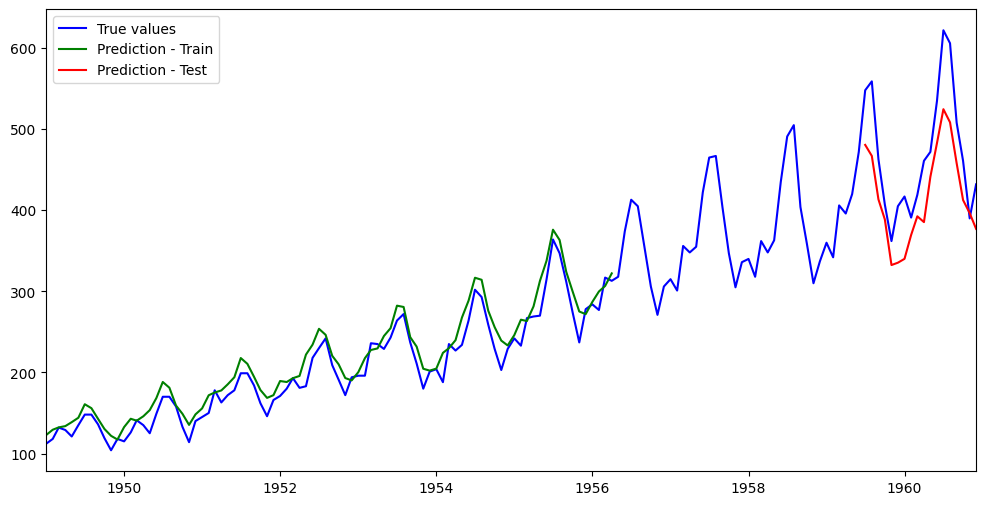

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(dataset['Passengers'], color='blue', label='True values')

plt.plot(prediction_train, color='green', label='Prediction - Train')
plt.plot(prediction_test, color='red', label='Prediction - Test')

plt.legend(loc='upper left')

# Ustawienie pełnego zakresu osi X
plt.xlim(dataset.index[0], dataset.index[-1])  # Pełny zakres czasu

plt.show()

In [23]:
y_pred = model_gru_final.predict(X_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


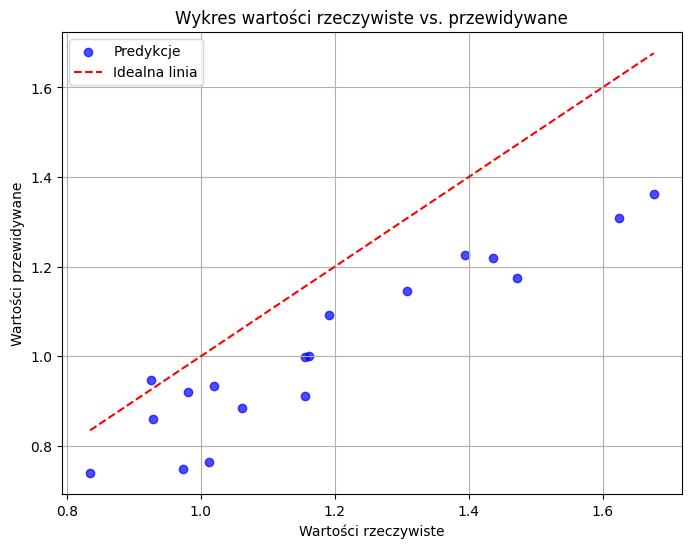

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color="blue", label="Predykcje")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--", label="Idealna linia")
plt.xlabel("Wartości rzeczywiste")
plt.ylabel("Wartości przewidywane")
plt.title("Wykres wartości rzeczywiste vs. przewidywane")
plt.legend()
plt.grid(True)
plt.show()